# BƯỚC 1: TÌM NEAR-OPTIMAL PATHS (Nearest Shortest Paths)

In [8]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ======== BƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD BẰNG NEAR-OPTIMAL PATHS ========

def build_expanded_graph(n_physical, edges):
    """Xây dựng đồ thị mở rộng với virtual nodes"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))  # Road to Road
            G_exp[(u, 1)].append(((v, 2), length))  # Road to Water
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))  # Water to Water
            G_exp[(u, 2)].append(((v, 1), length))  # Water to Road
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Thuật toán Dijkstra với multiple targets"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_shortest_paths(G_exp, n_physical, OD_pairs_physical):
    """Tìm đường đi ngắn nhất cho các cặp OD"""
    shortest_paths = {}
    
    print("TÌM ĐƯỜNG ĐI NGẮN NHẤT CHO CÁC CẶP OD:")
    print("=" * 50)
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f"\nTìm đường đi ngắn nhất từ {s} đến {t} cho commodity {commodity}")
            
            # Tìm đường đi ngắn nhất bằng Dijkstra
            min_length = float('inf')
            best_path = None
            
            for start_type in [1, 2]:
                dist = defaultdict(lambda: float('inf'))
                prev = {}
                heap = []
                
                start_node = (s, start_type)
                dist[start_node] = 0
                heapq.heappush(heap, (0, start_node))
                prev[start_node] = None
                
                while heap:
                    d, node = heapq.heappop(heap)
                    u, u_mode = node
                    
                    if u == t:
                        if d < min_length:
                            min_length = d
                            # Reconstruct path
                            path = []
                            current = node
                            while current is not None:
                                path.append(current)
                                current = prev.get(current)
                            path.reverse()
                            best_path = path
                        continue
                    
                    if d != dist[node]:
                        continue
                        
                    for neighbor, length in G_exp.get(node, []):
                        new_dist = d + length
                        if new_dist < dist[neighbor]:
                            dist[neighbor] = new_dist
                            prev[neighbor] = node
                            heapq.heappush(heap, (new_dist, neighbor))
            
            if best_path:
                shortest_paths[(commodity, (s, t))] = (best_path, min_length)
                print(f"  Đường đi ngắn nhất: {best_path}")
                print(f"  Độ dài: {min_length}")
            else:
                print(f"  Không tìm thấy đường đi từ {s} đến {t}")
    
    return shortest_paths

def find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical, epsilon=0.5, max_paths=1000, max_time=30):
    """Tìm tất cả các near-optimal paths cho các cặp OD"""
    all_paths_for_model = {}
    
    print(f"\nTÌM ĐƯỜNG ĐI GẦN NGẮN NHẤT (epsilon={epsilon}):")
    print("=" * 50)
    
    # First find shortest paths to establish baseline
    shortest_paths = find_shortest_paths(G_exp, n_physical, OD_pairs_physical)
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f"\nTìm đường gần ngắn nhất từ {s} đến {t} cho commodity {commodity}")
            
            # Get shortest path length for this OD pair
            shortest_key = (commodity, (s, t))
            if shortest_key not in shortest_paths:
                print(f"  Không có đường đi ngắn nhất, bỏ qua")
                continue
                
            shortest_path, shortest_length = shortest_paths[shortest_key]
            threshold = shortest_length * (1 + epsilon)
            
            print(f"  Độ dài đường ngắn nhất: {shortest_length}")
            print(f"  Ngưỡng near-optimal: {threshold:.2f}")
            
            # Tìm tất cả đường đi bằng DFS
            start_time = time.time()
            results = []
            for start_type in [1, 2]:
                visited_physical = [False] * n_physical
                visited_physical[s] = True
                stack = [((s, start_type), 0, [], visited_physical)]
                while stack:
                    if time.time() - start_time > max_time or len(results) >= max_paths:
                        break
                    node, total_length, path, visited = stack.pop()
                    u, _ = node
                    if u == t:
                        if total_length <= threshold:
                            results.append((path + [node], total_length))
                        continue
                    for next_node, length in G_exp.get(node, []):
                        v, _ = next_node
                        if not visited[v]:
                            new_path = path + [node]
                            new_length = total_length + length
                            if new_length <= threshold:  # Pruning
                                new_visited = visited.copy()
                                new_visited[v] = True
                                stack.append((next_node, new_length, new_path, new_visited))
            
            # Sort by length
            results.sort(key=lambda x: x[1])
            
            print(f"  Tìm thấy {len(results)} đường đi gần ngắn nhất")
            for i, (path, length) in enumerate(results):
                print(f"  Path {i+1}: Độ dài {length}, Tỷ lệ so với ngắn nhất: {length/shortest_length:.3f}")
            
            all_paths_for_model[(commodity, (s, t))] = results
    
    return all_paths_for_model, shortest_paths


# BƯỚC 2: DỮ LIỆU ĐẦU VÀO TỪ TOY EXAMPLE

In [9]:
# ======== BƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO ========

def process_input_data():
    """Xử lý và chuẩn bị dữ liệu đầu vào"""
    # Dữ liệu đồ thị vật lý
    n_physical = 5
    edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
    
    # Các cặp OD theo loại hàng hóa
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]            # Rice
    }
    
    return n_physical, edges, OD_pairs_physical

# BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS (ε = 0.5)

In [10]:
# ======== BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS ========

def convert_path_to_model_format(path, length):
    """Chuyển đổi đường đi từ định dạng mở rộng sang định dạng mô hình"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        
        # Tạo real arc từ u đến virtual node của v
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        
        # Nếu không phải là bước cuối, thêm virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    
    # Thêm virtual arc cho đích
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    
    return arcs, length

def prepare_optimization_data(all_paths_for_model):
    """Chuẩn bị dữ liệu cho mô hình tối ưu"""
    # Chuyển đổi tất cả paths sang định dạng mô hình
    paths_converted = {}
    for key, path_list in all_paths_for_model.items():
        converted_paths = []
        for path, length in path_list:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append((model_path, path_length))
        paths_converted[key] = converted_paths
    
    # Điều chỉnh node từ 0-based sang 1-based
    paths_adjusted = {}
    for (commodity, orig_od), path_list in paths_converted.items():
        orig_s, orig_t = orig_od
        new_od = (orig_s + 1, orig_t + 1)
        paths_adjusted[(commodity, new_od)] = path_list
    
    return paths_adjusted

# BƯỚC 4: CHUYỂN PATHS → VIRTUAL ARCS (dùng trong PuLP) và giải mô hình tối ưu 

In [11]:
# ======== BƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU ========

def create_optimization_model(paths_adjusted):
    """Tạo và giải mô hình tối ưu"""
    # 1. SETUP INPUT DATA
    T = [1, 2]  # Các giai đoạn thời gian
    
    # Định nghĩa nodes
    real_nodes = [1, 2, 3, 4, 5]  # 1-based nodes
    virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
    all_nodes = real_nodes + virtual_nodes
    
    # Hubs
    H = [3]  # Cần Thơ
    potential_hubs = [3]
    existing_hubs = []
    
    # Thu thập tất cả các arc từ các đường đi đã tìm
    real_arcs = []
    virtual_arcs = []
    
    for path_list in paths_adjusted.values():
        for path, _ in path_list:
            for arc in path:
                if '^' in str(arc[1]):  # Real arc
                    if arc not in real_arcs:
                        real_arcs.append(arc)
                else:  # Virtual arc
                    if arc not in virtual_arcs:
                        virtual_arcs.append(arc)
    
    print(f"\nReal arcs: {real_arcs}")
    print(f"Virtual arcs: {virtual_arcs}")
    
    # All arcs
    A = real_arcs + virtual_arcs
    potential_arcs = [(3, '4^1'), (3, '4^2')]  # Các arc có thể nâng cấp
    existing_arcs = [arc for arc in A if arc not in potential_arcs]
    
    # Commodities
    commodities = {'passenger': 'g1', 'rice': 'g2'}
    
    # Origin-Destination pairs (1-based)
    OD_pairs = {
        'g1': [(1, 4), (2, 5)],  # Passenger
        'g2': [(2, 4)]           # Rice
    }
    
    # Transportation costs on arcs
    arc_costs = {}
    for arc in real_arcs:
        arc_costs[arc] = 1  # Giá mặc định
    for arc in virtual_arcs:
        arc_costs[arc] = 0  # Virtual arcs có cost = 0
    
    # Các tham số khác
    switch_cost = 2
    hub_service_cost = {3: 1}
    hub_upgrade_cost = 1000
    hub_capacity = {0: 2000, 1: 7000}
    
    arc_upgrade_costs = {
        (3, '4^1'): 800,
        (3, '4^2'): 500
    }
    
    arc_capacities = {
        (3, '4^1'): {0: 0, 1: 3000},
        (3, '4^2'): {0: 0, 1: 4000}
    }
    
    existing_hub_capacity = 2000
    existing_arc_capacity = 2000
    
    # Transportation demand
    demands = {
        ('g1', (1, 4)): 3000,  # Passenger từ An Giang -> TP.HCM
        ('g1', (2, 5)): 2800,  # Passenger từ Đồng Tháp -> Vĩnh Long
        ('g2', (2, 4)): 4000   # Rice từ Đồng Tháp -> TP.HCM
    }
    
    # 2. INITIALIZE MODEL AND DECISION VARIABLES
    model = pulp.LpProblem("Multimodal_Transport_Network_Optimization", pulp.LpMinimize)
    
    # Decision variables
    y_hub = pulp.LpVariable.dicts(
        "y_hub", 
        [(h, l, t) for h in potential_hubs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    y_arc = pulp.LpVariable.dicts(
        "y_arc", 
        [(a[0], a[1], l, t) for a in potential_arcs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    v_path = {}
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for idx, _ in enumerate(paths_adjusted[(g, od)]):
                for t in T:
                    v_name = f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}"
                    v_path[(g, od, idx, t)] = pulp.LpVariable(v_name, lowBound=0, upBound=1)
    
    u_hub = pulp.LpVariable.dicts(
        "u_hub", 
        [(h, t) for h in H for t in T],
        lowBound=0
    )
    
    x_arc = pulp.LpVariable.dicts(
        "x_arc", 
        [(a[0], a[1], t) for a in A for t in T],
        lowBound=0
    )
    
    # 3. BUILD OBJECTIVE FUNCTION
    investment_cost = pulp.lpSum(
        [hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)] 
            for h in potential_hubs for l in [0, 1] for t in T] 
        + 
        [arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
            for a in potential_arcs for l in [0, 1] for t in T]
    )
    
    service_cost = pulp.lpSum(
        hub_service_cost[h] * u_hub[(h, t)] 
        for h in H for t in T
    )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            demand = demands[(g, od)]
            for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                # Tính path transport cost
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += arc_costs[arc]
                    
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * switch_cost
                
                for t in T:
                    transport_cost += path_cost * demand * v_path[(g, od, idx, t)]
    
    model += investment_cost + service_cost + transport_cost
    
    # 4. CONSTRAINTS
    # Flow allocation constraint
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for t in T:
                model += pulp.lpSum(v_path[(g, od, idx, t)] for idx in range(len(paths_adjusted[(g, od)]))) == 1
    
    # Calculate flow through hubs
    for h in H:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if any(arc[1] == str(h) or arc[1] == h for arc in path):
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += u_hub[(h, t)] == total_flow
    
    # Calculate flow through arcs
    for arc in A:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if arc in path:
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += x_arc[(arc[0], arc[1], t)] == total_flow
    
    # Hub capacity constraints
    for h in potential_hubs:
        for t in T:
            model += u_hub[(h, t)] <= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    # Arc capacity constraints
    for a in potential_arcs:
        for t in T:
            model += x_arc[(a[0], a[1], t)] <= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
                for l in [0, 1]
            )
    
    for a in existing_arcs:
        if a in real_arcs:
            for t in T:
                model += x_arc[(a[0], a[1], t)] <= existing_arc_capacity
    
    # Logic constraints
    for h in potential_hubs:
        for t in T:
            model += pulp.lpSum(y_hub[(h, l, t)] for l in [0, 1]) == 1
    
    for a in potential_arcs:
        for t in T:
            model += pulp.lpSum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1
    
    # Non-decreasing capacity constraints
    for h in potential_hubs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    for a in potential_arcs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]
            )
    
    return model, {
        'y_hub': y_hub, 'y_arc': y_arc, 'v_path': v_path, 
        'u_hub': u_hub, 'x_arc': x_arc,
        'OD_pairs': OD_pairs, 'paths_adjusted': paths_adjusted,
        'demands': demands, 'commodities': commodities,
        'potential_hubs': potential_hubs, 'potential_arcs': potential_arcs,
        'T': T, 'real_nodes': real_nodes, 'virtual_nodes': virtual_nodes,
        'real_arcs': real_arcs, 'virtual_arcs': virtual_arcs
    }

def solve_and_display_results(model, data):
    """Giải mô hình và hiển thị kết quả"""
    print("\n" + "="*50)
    print("BẮT ĐẦU GIẢI MÔ HÌNH TỐI ƯU")
    print("="*50)
    
    model.solve()
    
    print(f"Trạng thái giải: {pulp.LpStatus[model.status]}")
    print(f"Tổng chi phí tối ưu: {pulp.value(model.objective):.2f}\n")
    
    # Hiển thị kết quả
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "Đồng Tháp", 
            2: "Cần Thơ",
            3: "TP.HCM",
            4: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    
    print("KẾT QUẢ TỐI ƯU:")
    
    # Hiển thị các biến quyết định
    print("\n[1] KẾ HOẠCH ĐẦU TƯ - NÂNG CẤP HUB:")
    hub_investment = {}
    for h in data['potential_hubs']:
        hub_investment[h] = {}
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_hub'][(h, l, t)]) > 0.5:
                    capacity = 2000 if l == 0 else 7000
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    hub_investment[h][t] = (action, capacity)
                    print(f"  Hub {get_province_name(h-1)} - Giai đoạn {t}: {action} (công suất: {capacity})")
    
    print("\n[2] KẾ HOẠCH ĐẦU TƯ - NÂNG CẤP ARC:")
    arc_investment = {}
    for a in data['potential_arcs']:
        arc_investment[a] = {}
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_arc'][(a[0], a[1], l, t)]) > 0.5:
                    capacity = 0 if l == 0 else (3000 if '^1' in a[1] else 4000)
                    mode = "ĐƯỜNG BỘ" if '^1' in a[1] else "ĐƯỜNG THỦY"
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    arc_investment[a][t] = (action, capacity, mode)
                    print(f"  Arc {get_province_name(a[0]-1)}→{get_province_name(int(a[1].split('^')[0])-1)} ({mode}) - Giai đoạn {t}: {action} (công suất: {capacity})")
    
    print("\n[3] PHÂN BỔ LUỒNG VẬN TẢI:")
    flow_allocation = {}
    for g_name, g_code in data['commodities'].items():
        flow_allocation[g_code] = {}
        print(f"\n  Mặt hàng: {g_name.upper()}")
        for od in data['OD_pairs'][g_code]:
            origin, dest = od
            flow_allocation[g_code][od] = {}
            print(f"    Tuyến: {get_province_name(origin-1)} → {get_province_name(dest-1)}")
            for t in data['T']:
                flow_allocation[g_code][od][t] = []
                print(f"      Giai đoạn {t}:")
                total_flow = 0
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(g_code, od)]):
                    flow_value = pulp.value(data['v_path'][(g_code, od, idx, t)])
                    if flow_value is not None and flow_value > 0.001:
                        flow_amount = data['demands'][(g_code, od)] * flow_value
                        total_flow += flow_amount
                        flow_allocation[g_code][od][t].append((idx, flow_amount, path))
                        path_desc = " → ".join([f"{get_province_name(arc[0]-1) if isinstance(arc[0], int) else arc[0]}->{get_province_name(arc[1]-1) if isinstance(arc[1], int) else arc[1]}" for arc in path])
                        print(f"        Path {idx+1}: {flow_amount:.2f} đơn vị")
                        print(f"          Route: {path_desc}")
                print(f"        Tổng luồng: {total_flow:.2f}")
    
    print("\n[4] TỔNG HỢP CHI PHÍ:")
    investment_cost = pulp.lpSum(
        [1000 * (2000 if l == 0 else 7000) * data['y_hub'][(h, l, t)] 
            for h in data['potential_hubs'] for l in [0, 1] for t in data['T']] 
        + 
        [({(3, '4^1'): 800, (3, '4^2'): 500}[a] * ({0: 0, 1: 3000} if '^1' in a[1] else {0: 0, 1: 4000})[l] * data['y_arc'][(a[0], a[1], l, t)]) 
            for a in data['potential_arcs'] for l in [0, 1] for t in data['T']]
    )
    
    service_cost = pulp.lpSum(
        1 * data['u_hub'][(h, t)] 
        for h in [3] for t in data['T']
    )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(g, od)]
            for idx, (path, _) in enumerate(data['paths_adjusted'][(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += (1 if '^' in str(arc[1]) else 0)
                    
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * 2
                
                for t in data['T']:
                    transport_cost += path_cost * demand * data['v_path'][(g, od, idx, t)]
    
    print(f"  Chi phí đầu tư: {pulp.value(investment_cost):.2f}")
    print(f"  Chi phí dịch vụ hub: {pulp.value(service_cost):.2f}") 
    print(f"  Chi phí vận tải: {pulp.value(transport_cost):.2f}")
    print(f"  TỔNG CỘNG: {pulp.value(model.objective):.2f}")
    
    return model, hub_investment, arc_investment, flow_allocation



# BƯỚC 5: Visualization

In [12]:
# ======== PHẦN VISUALIZATION ========

def draw_original_network(n_physical, edges):
    """Vẽ đồ thị ban đầu với các phương thức vận tải tách biệt"""
    plt.figure(figsize=(14, 10))
    
    # Tạo đồ thị
    G = nx.MultiDiGraph()
    
    # Thêm nodes
    for i in range(n_physical):
        G.add_node(i)
    
    # Thêm edges với thông tin mode
    for u, v, mode, length in edges:
        G.add_edge(u, v, mode=mode, length=length)
    
    # Tạo layout
    pos = {
        0: (0, 2),   # An Giang
        1: (2, 3),   # Đồng Tháp
        2: (4, 2),   # Cần Thơ
        3: (6, 3),   # TP.HCM
        4: (2, 1)    # Vĩnh Long
    }
    
    # Vẽ nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1500, alpha=0.9)
    
    # Vẽ labels cho nodes
    node_labels = {0: 'An Giang', 1: 'Đồng Tháp', 2: 'Cần Thơ', 
                  3: 'TP.HCM', 4: 'Vĩnh Long'}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')
    
    # Vẽ edges theo từng mode
    road_edges = [(u, v) for u, v, mode, length in edges if mode == 1]
    water_edges = [(u, v) for u, v, mode, length in edges if mode == 2]
    
    # Vẽ đường bộ (màu đỏ)
    nx.draw_networkx_edges(G, pos, edgelist=road_edges,
                          edge_color='red', width=2,
                          arrows=True, arrowsize=20,
                          label='Đường bộ')
    
    # Vẽ đường thủy (màu xanh)
    nx.draw_networkx_edges(G, pos, edgelist=water_edges,
                          edge_color='blue', width=2, style='dashed',
                          arrows=True, arrowsize=20,
                          label='Đường thủy')
    
    # Thêm nhãn cho edges
    edge_labels = {}
    for u, v, mode, length in edges:
        edge_labels[(u, v, mode)] = f'{length}'
    
    # Vẽ nhãn cho đường bộ
    road_labels = {(u, v): f'{length}' for u, v, mode, length in edges if mode == 1}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=road_labels, font_size=8, label_pos=0.3)
    
    # Vẽ nhãn cho đường thủy
    water_labels = {(u, v): f'{length}' for u, v, mode, length in edges if mode == 2}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=water_labels, font_size=8, label_pos=0.7)
    
    plt.title("ĐỒ THỊ MẠNG LƯỚI VẬN TẢI BAN ĐẦU\n(Đường bộ: màu đỏ, Đường thủy: màu xanh nét đứt)", 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('original_network.png', dpi=300, bbox_inches='tight')
    plt.show()

def draw_shortest_paths(shortest_paths):
    """Vẽ các đường đi ngắn nhất"""
    plt.figure(figsize=(14, 10))
    
    G = nx.DiGraph()
    
    # Tạo layout
    pos = {
        0: (0, 2),   # An Giang
        1: (2, 3),   # Đồng Tháp
        2: (4, 2),   # Cần Thơ
        3: (6, 3),   # TP.HCM
        4: (2, 1)    # Vĩnh Long
    }
    
    # Thêm tất cả nodes
    for i in range(5):
        G.add_node(i)
    
    # Màu sắc cho các commodity
    colors = {'g1': 'red', 'g2': 'green'}
    labels = {'g1': 'Hành khách', 'g2': 'Gạo'}
    
    # Vẽ nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1500, alpha=0.9)
    
    # Vẽ labels cho nodes
    node_labels = {0: 'An Giang', 1: 'Đồng Tháp', 2: 'Cần Thơ', 
                  3: 'TP.HCM', 4: 'Vĩnh Long'}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')
    
    # Vẽ các đường đi ngắn nhất
    legend_handles = []
    for (commodity, od), (path, length) in shortest_paths.items():
        s, t = od
        color = colors.get(commodity, 'black')
        label = labels.get(commodity, commodity)
        
        # Thêm edges từ path
        for i in range(len(path) - 1):
            u, u_mode = path[i]
            v, v_mode = path[i+1]
            G.add_edge(u, v, commodity=commodity, mode=u_mode)
        
        # Vẽ edges với màu tương ứng
        edges = [(u, v) for u, v, data in G.edges(data=True) 
                if data.get('commodity') == commodity]
        
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges,
                                  edge_color=color, width=3,
                                  arrows=True, arrowsize=25,
                                  style='dashed' if commodity == 'g2' else 'solid')
            
            # Thêm vào legend
            from matplotlib.lines import Line2D
            legend_handles.append(Line2D([0], [0], color=color, lw=3, 
                                       label=f'{label} (độ dài: {length})'))
    
    plt.title("CÁC ĐƯỜNG ĐI NGẮN NHẤT CHO CÁC CẶP OD", 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(handles=legend_handles, loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('shortest_paths.png', dpi=300, bbox_inches='tight')
    plt.show()

def draw_upgrade_plan(hub_investment, arc_investment):
    """Vẽ kế hoạch nâng cấp theo từng chu kỳ"""
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "Đồng Tháp", 
            2: "Cần Thơ",
            3: "TP.HCM",
            4: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    
    for t in [1, 2]:
        plt.figure(figsize=(14, 10))
        
        G = nx.DiGraph()
        
        # Tạo layout
        pos = {
            0: (0, 2),   # An Giang
            1: (2, 3),   # Đồng Tháp
            2: (4, 2),   # Cần Thơ
            3: (6, 3),   # TP.HCM
            4: (2, 1)    # Vĩnh Long
        }
        
        # Thêm nodes
        for i in range(5):
            G.add_node(i)
        
        # Vẽ nodes
        node_colors = []
        for i in range(5):
            if i == 2:  # Cần Thơ - hub
                if 3 in hub_investment and t in hub_investment[3]:
                    action, capacity = hub_investment[3][t]
                    if action == "NÂNG CẤP":
                        node_colors.append('orange')
                    else:
                        node_colors.append('lightblue')
                else:
                    node_colors.append('lightblue')
            else:
                node_colors.append('lightblue')
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              node_size=1500, alpha=0.9)
        
        # Vẽ labels cho nodes
        node_labels = {0: 'An Giang', 1: 'Đồng Tháp', 2: 'Cần Thơ', 
                      3: 'TP.HCM', 4: 'Vĩnh Long'}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')
        
        # Vẽ các arcs cần nâng cấp
        legend_handles = []
        
        # Arc từ Cần Thơ đến TP.HCM
        for arc, investment_info in arc_investment.items():
            if t in investment_info:
                action, capacity, mode = investment_info[t]
                u, v_str = arc
                v = int(v_str.split('^')[0]) - 1  # Chuyển về 0-based
                
                color = 'red' if 'BỘ' in mode else 'blue'
                style = 'solid' if action == "NÂNG CẤP" else 'dashed'
                width = 4 if action == "NÂNG CẤP" else 2
                
                G.add_edge(u-1, v, action=action, mode=mode)
                
                edges = [(u-1, v)]
                nx.draw_networkx_edges(G, pos, edgelist=edges,
                                      edge_color=color, width=width,
                                      style=style, arrows=True, arrowsize=25)
                
                # Thêm vào legend
                from matplotlib.lines import Line2D
                status = "ĐÃ NÂNG CẤP" if action == "NÂNG CẤP" else "GIỮ NGUYÊN"
                legend_handles.append(Line2D([0], [0], color=color, lw=width, 
                                           linestyle=style,
                                           label=f'{mode} - {status} (công suất: {capacity})'))
        
        plt.title(f"KẾ HOẠCH NÂNG CẤP - GIAI ĐOẠN {t}", 
                 fontsize=16, fontweight='bold', pad=20)
        plt.legend(handles=legend_handles, loc='upper right')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'upgrade_plan_t{t}.png', dpi=300, bbox_inches='tight')
        plt.show()


def draw_flow_distribution(flow_allocation, commodities, T):
    """Vẽ phân bổ luồng cho từng loại hàng hóa theo thời kỳ"""
    def get_province_name(node_id):
        names = {
            0: "An Giang",
            1: "Đồng Tháp", 
            2: "Cần Thơ",
            3: "TP.HCM",
            4: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    
    def normalize_node(node):
        """Chuẩn hóa node về định dạng 0-based"""
        if isinstance(node, int):
            # Nếu là node thực (1-based), chuyển về 0-based
            if node >= 1 and node <= 5:
                return node - 1
            else:
                return node  # Giữ nguyên nếu đã là 0-based
        elif isinstance(node, str) and '^' in node:
            # Virtual node: '3^1' -> node thực là 2 (0-based)
            base_node = int(node.split('^')[0])
            return base_node - 1
        return node
    
    commodity_styles = {
        'g1': {'color': 'red', 'style': 'solid', 'marker': 'o'},
        'g2': {'color': 'green', 'style': 'dashed', 'marker': 's'}
    }
    
    commodity_names = {
        'g1': 'Hành khách',
        'g2': 'Gạo'
    }
    
    for g_code, od_flows in flow_allocation.items():
        for t in T:
            plt.figure(figsize=(14, 10))
            
            G = nx.DiGraph()
            
            # Tạo layout cho nodes 0-based
            pos = {
                0: (0, 2),   # An Giang
                1: (2, 3),   # Đồng Tháp
                2: (4, 2),   # Cần Thơ
                3: (6, 3),   # TP.HCM
                4: (2, 1)    # Vĩnh Long
            }
            
            # Thêm nodes (0-based)
            for i in range(5):
                G.add_node(i)
            
            # Vẽ nodes
            nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                  node_size=1500, alpha=0.9)
            
            # Vẽ labels cho nodes
            node_labels = {0: 'An Giang', 1: 'Đồng Tháp', 2: 'Cần Thơ', 
                          3: 'TP.HCM', 4: 'Vĩnh Long'}
            nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')
            
            # Tổng hợp luồng trên các cung
            edge_flows = {}
            
            for od, time_flows in od_flows.items():
                if t in time_flows:
                    for path_info in time_flows[t]:
                        idx, flow_amount, path = path_info
                        for i in range(len(path)):
                            # Chỉ xét các cung thực (real arcs), bỏ qua virtual arcs
                            u, v = path[i]
                            
                            # Chuẩn hóa cả hai node về 0-based
                            u_norm = normalize_node(u)
                            v_norm = normalize_node(v)
                            
                            # Chỉ thêm cung nếu cả hai node đều hợp lệ (0-4)
                            if u_norm is not None and v_norm is not None and u_norm >= 0 and u_norm <= 4 and v_norm >= 0 and v_norm <= 4:
                                edge = (u_norm, v_norm)
                                if edge not in edge_flows:
                                    edge_flows[edge] = 0
                                edge_flows[edge] += flow_amount
            
            # Bỏ qua nếu không có luồng
            if not edge_flows:
                print(f"Không có luồng cho {commodity_names[g_code]} ở giai đoạn {t}")
                plt.close()
                continue
            
            # Vẽ edges với độ dày tỷ lệ với luồng
            max_flow = max(edge_flows.values()) if edge_flows else 1
            legend_handles = []
            
            for edge, flow in edge_flows.items():
                u, v = edge
                # Chỉ thêm edge nếu cả hai node đều có trong pos
                if u in pos and v in pos:
                    G.add_edge(u, v, flow=flow)
                    
                    width = max(1, flow / max_flow * 10)
                    style = commodity_styles[g_code]['style']
                    color = commodity_styles[g_code]['color']
                    
                    edges_to_draw = [(u, v)]
                    nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw,
                                          edge_color=color, width=width,
                                          style=style, arrows=True, arrowsize=25)
            
            # Thêm legend
            from matplotlib.lines import Line2D
            legend_handles.append(Line2D([0], [0], color=commodity_styles[g_code]['color'], 
                                       lw=3, label=f'{commodity_names[g_code]}'))
            
            # Thêm nhãn luồng cho các cung
            edge_labels = {}
            for u, v, data in G.edges(data=True):
                if 'flow' in data:
                    edge_labels[(u, v)] = f"{data['flow']:.0f}"
            
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
            
            plt.title(f"PHÂN BỔ LUỒNG VẬN TẢI - {commodity_names[g_code].upper()} - GIAI ĐOẠN {t}\n(Độ dày thể hiện lượng luồng)", 
                     fontsize=16, fontweight='bold', pad=20)
            plt.legend(handles=legend_handles, loc='upper right')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'flow_distribution_{g_code}_t{t}.png', dpi=300, bbox_inches='tight')
            plt.show()

                     


# HÀM CHÍNH VÀ KẾT QUẢ IN RA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


BẮT ĐẦU CHƯƠNG TRÌNH TỐI ƯU MẠNG LƯỚI VẬN TẢI ĐA PHƯƠNG THỨC

BƯỚC 1 & 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO
----------------------------------------
Số nodes vật lý: 5
Số cung đường: 13
Số cặp OD: 3

Vẽ đồ thị ban đầu...


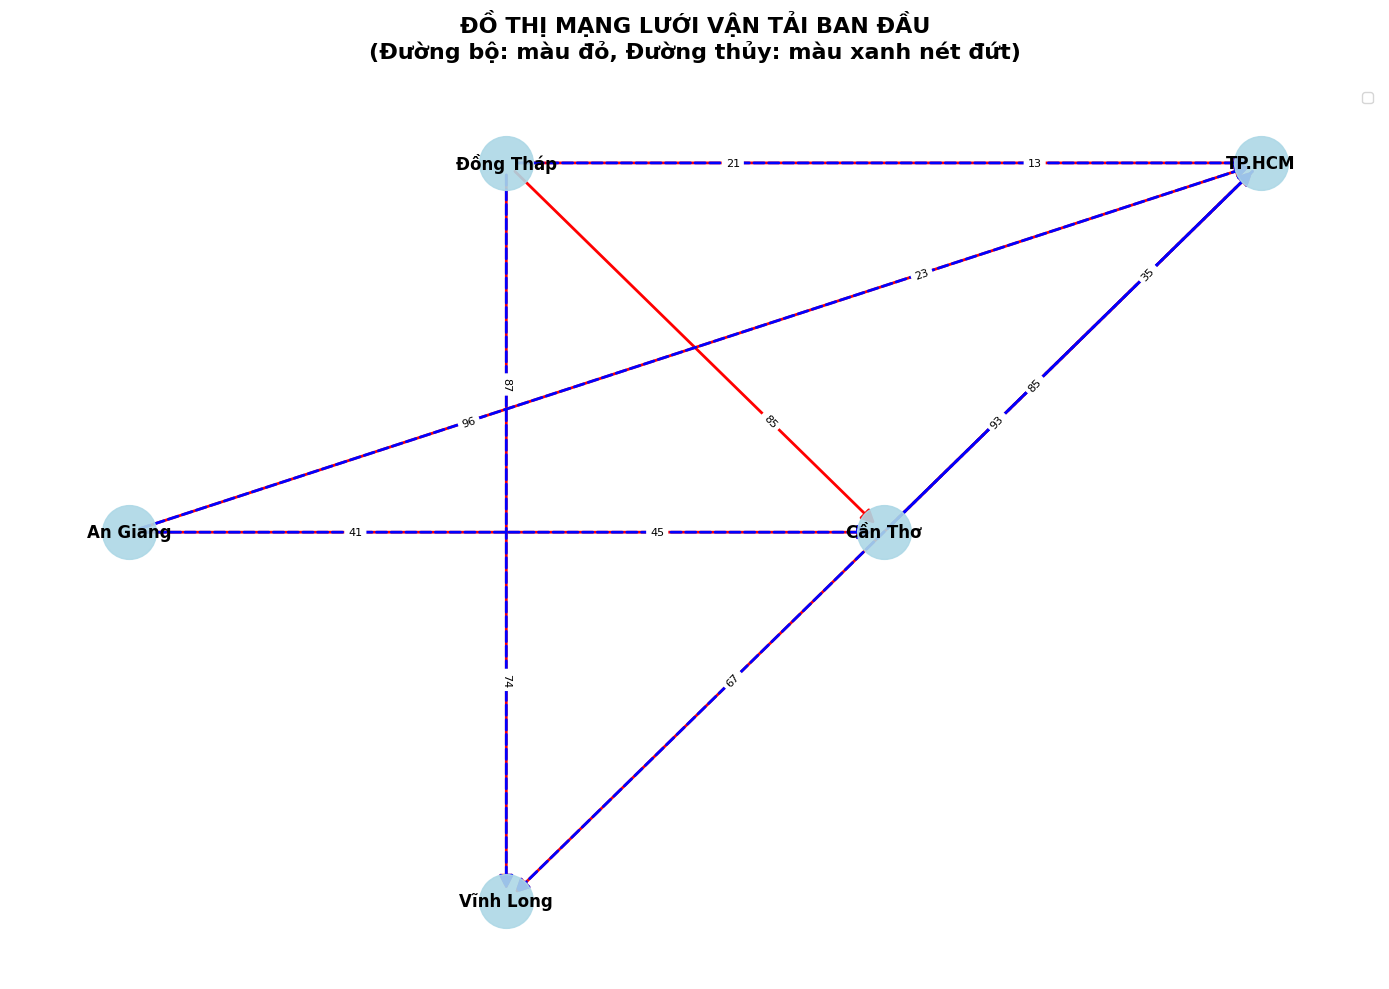


TÌM ĐƯỜNG ĐI GẦN NGẮN NHẤT (epsilon=0.5):
TÌM ĐƯỜNG ĐI NGẮN NHẤT CHO CÁC CẶP OD:

Tìm đường đi ngắn nhất từ 0 đến 3 cho commodity g1
  Đường đi ngắn nhất: [(0, 1), (3, 1)]
  Độ dài: 23

Tìm đường đi ngắn nhất từ 1 đến 4 cho commodity g1
  Đường đi ngắn nhất: [(1, 1), (4, 1)]
  Độ dài: 74

Tìm đường đi ngắn nhất từ 1 đến 3 cho commodity g2
  Đường đi ngắn nhất: [(1, 1), (3, 1)]
  Độ dài: 13

Tìm đường gần ngắn nhất từ 0 đến 3 cho commodity g1
  Độ dài đường ngắn nhất: 23
  Ngưỡng near-optimal: 34.50
  Tìm thấy 2 đường đi gần ngắn nhất
  Path 1: Độ dài 23, Tỷ lệ so với ngắn nhất: 1.000
  Path 2: Độ dài 23, Tỷ lệ so với ngắn nhất: 1.000

Tìm đường gần ngắn nhất từ 1 đến 4 cho commodity g1
  Độ dài đường ngắn nhất: 74
  Ngưỡng near-optimal: 111.00
  Tìm thấy 12 đường đi gần ngắn nhất
  Path 1: Độ dài 74, Tỷ lệ so với ngắn nhất: 1.000
  Path 2: Độ dài 74, Tỷ lệ so với ngắn nhất: 1.000
  Path 3: Độ dài 80, Tỷ lệ so với ngắn nhất: 1.081
  Path 4: Độ dài 80, Tỷ lệ so với ngắn nhất: 1.081
  Pa

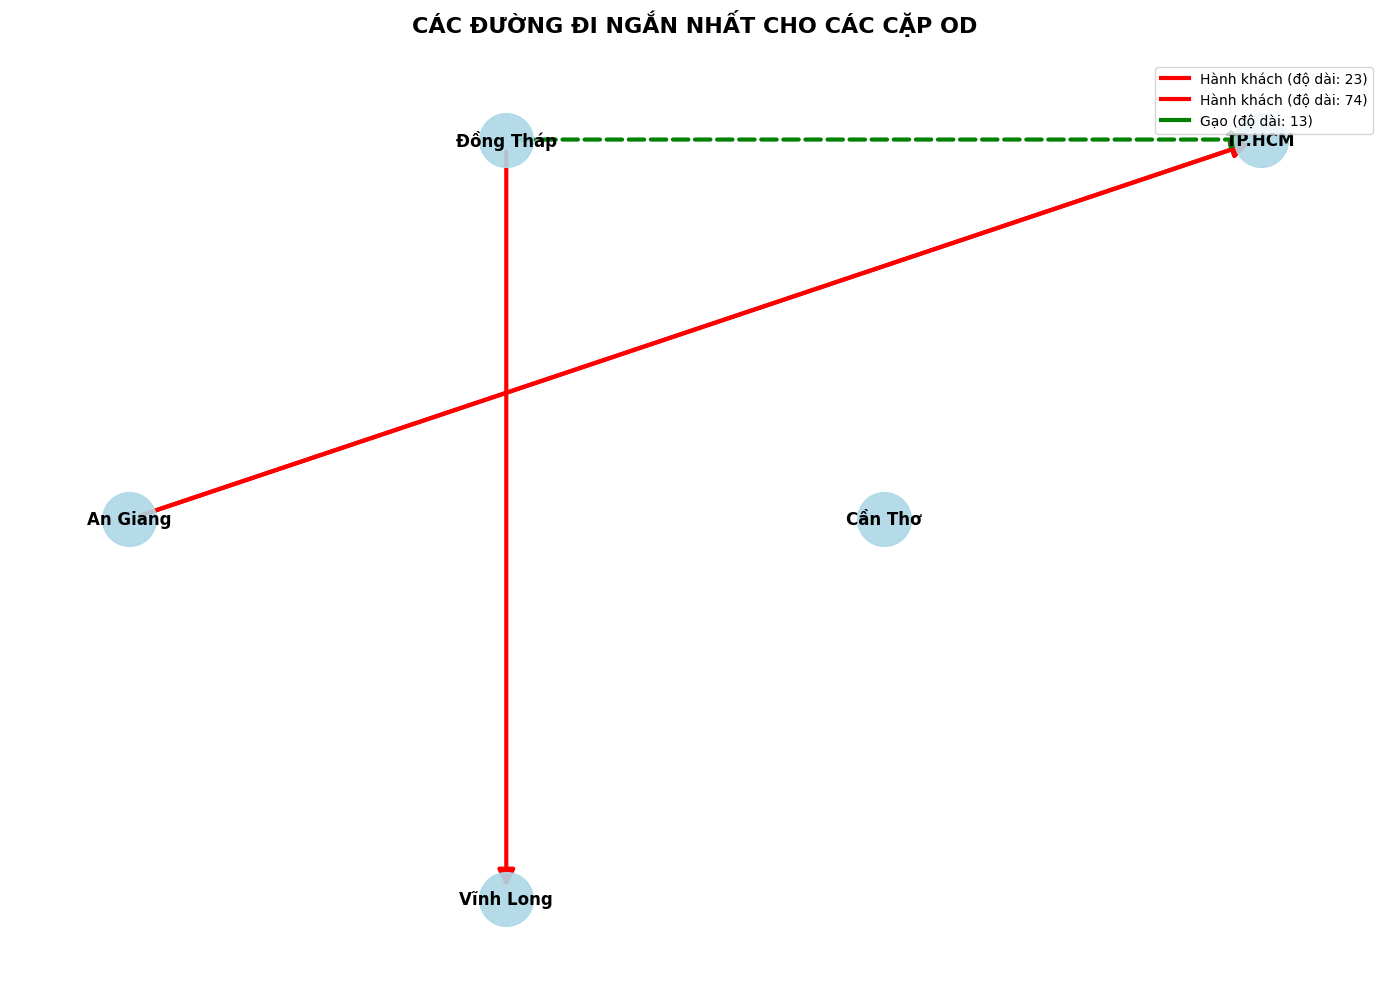


BƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU
------------------------------------------------------------

Real arcs: [(0, '3^2'), (0, '3^1'), (1, '4^2'), (1, '4^1'), (1, '3^1'), (3, '4^2'), (3, '4^1'), (1, '3^2')]
Virtual arcs: [('3^2', 3), ('3^1', 3), ('4^2', 4), ('4^1', 4)]

BẮT ĐẦU GIẢI MÔ HÌNH TỐI ƯU
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/dinhxuantruong/2022/Jupyter/test_env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/a1b68ec9972540279606fb69489fe90c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/a1b68ec9972540279606fb69489fe90c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 64 COLUMNS
At line 355 RHS
At line 415 BOUNDS
At line 460 ENDATA
Problem MODEL has 59 rows, 70 columns and 224 elements
Coin0008I MODEL read with 0 errors
Option

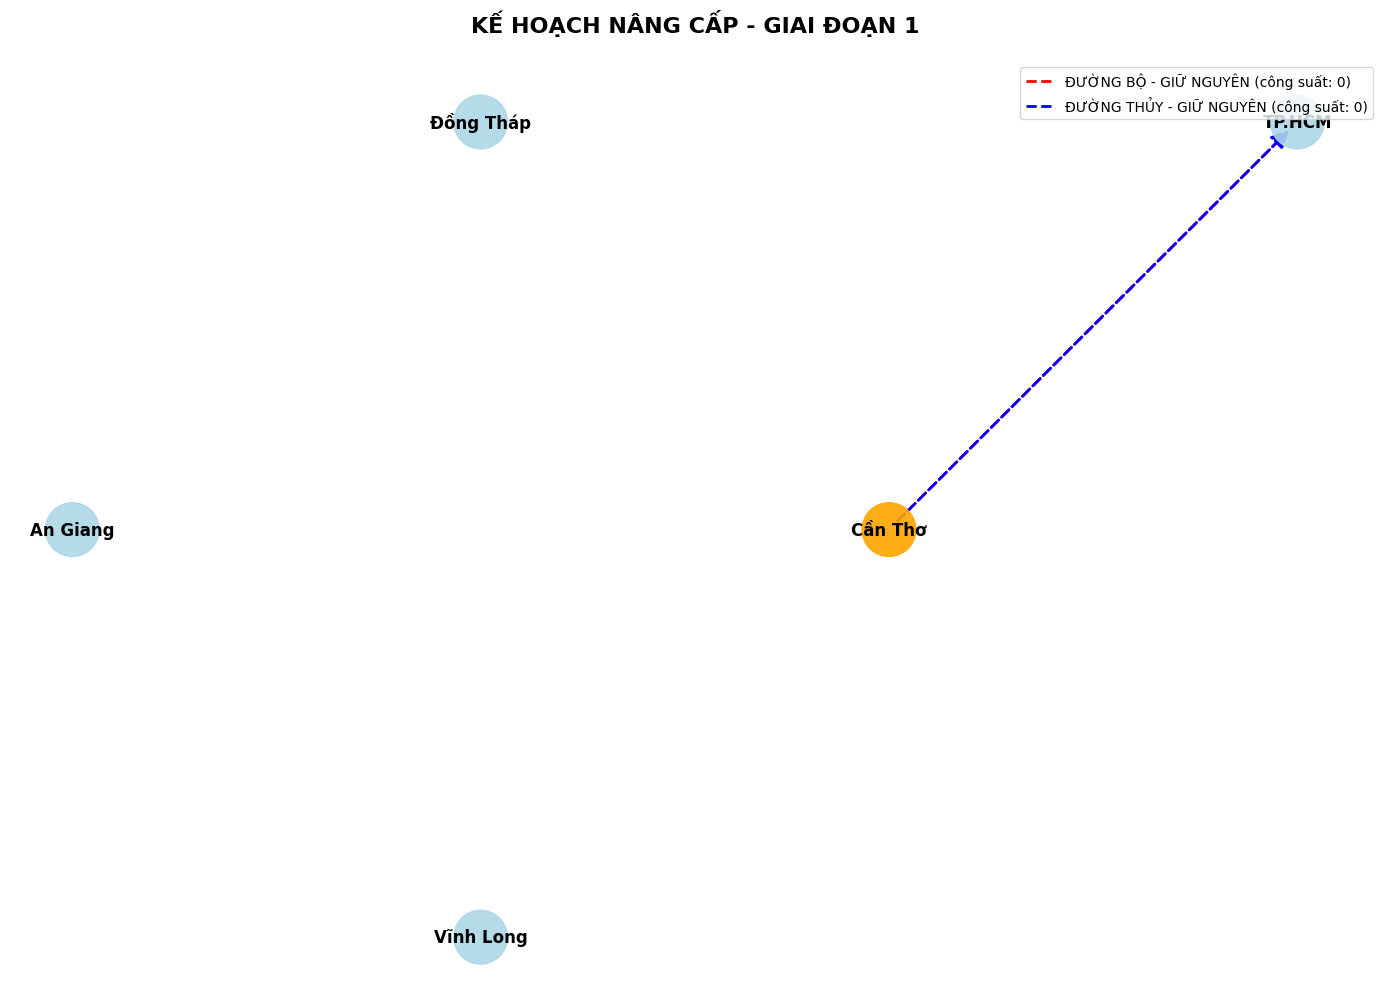

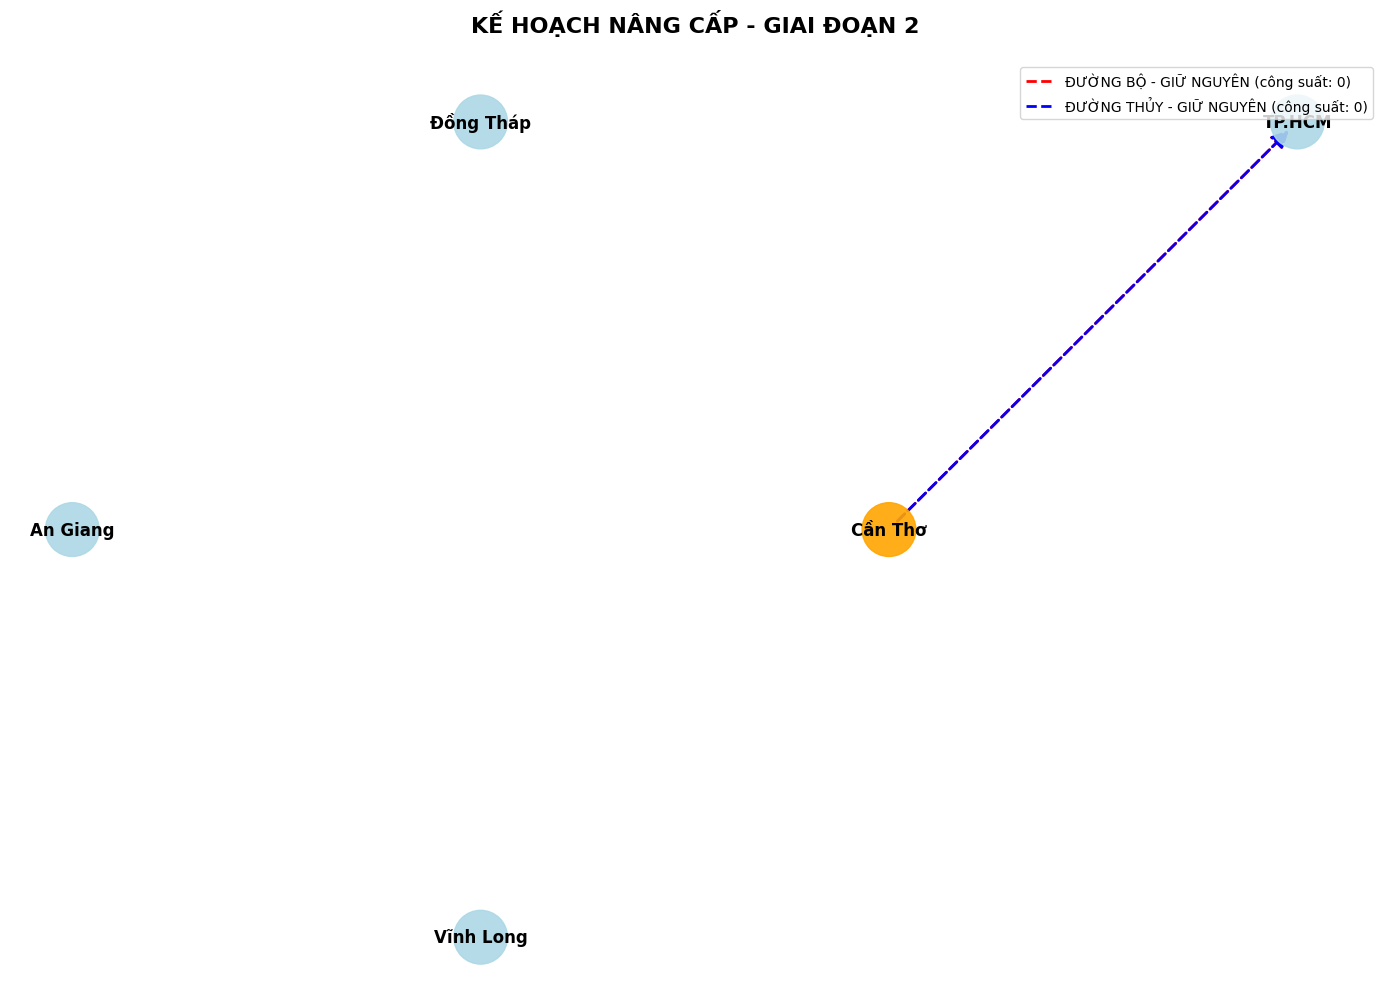

Vẽ phân bổ luồng...


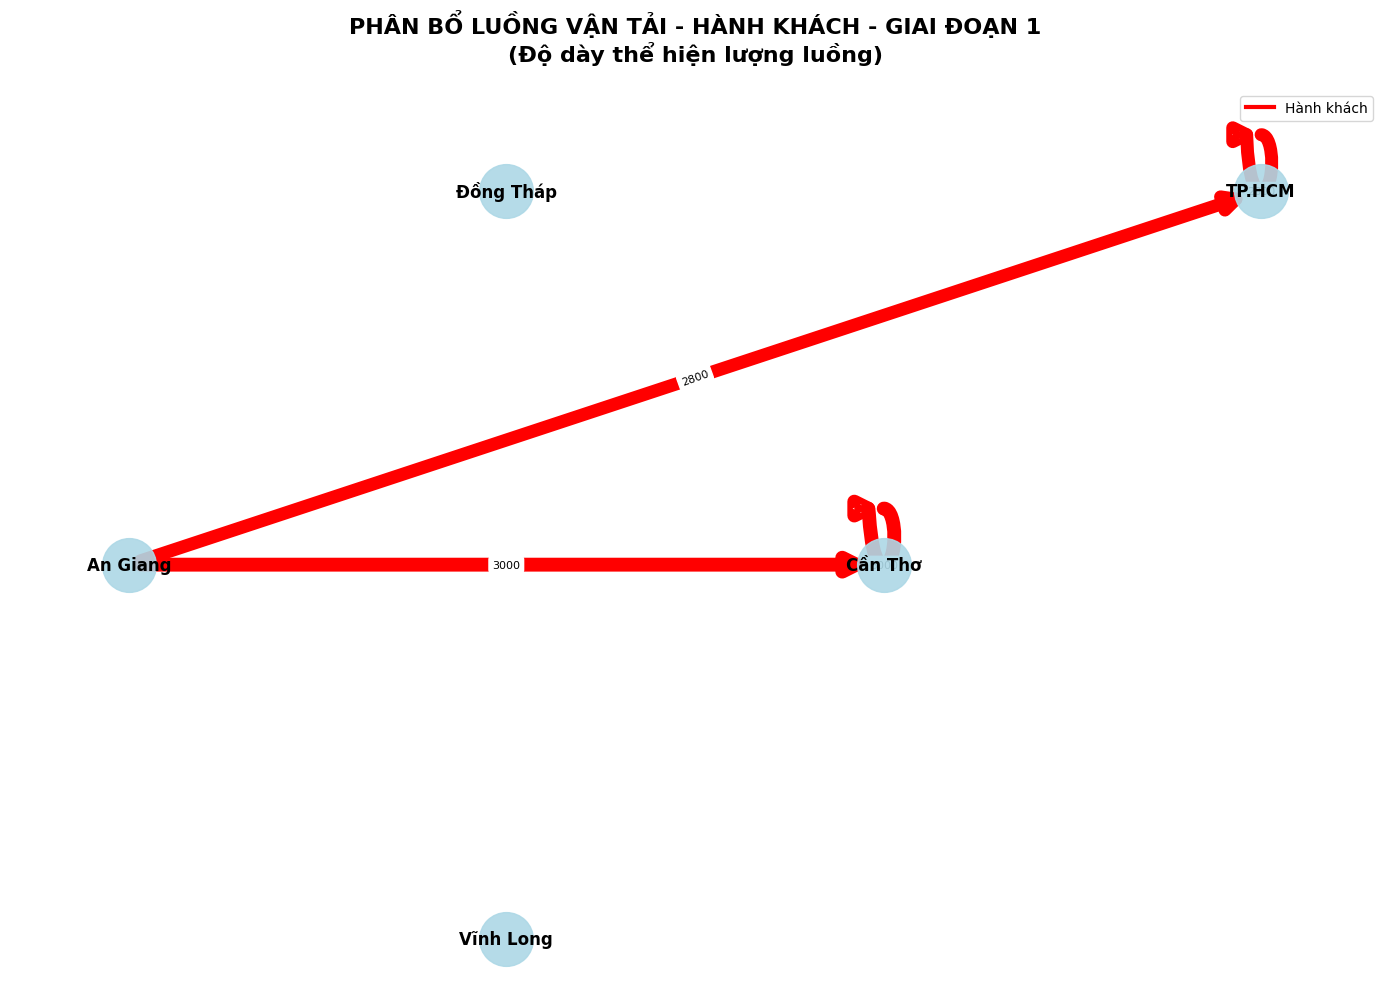

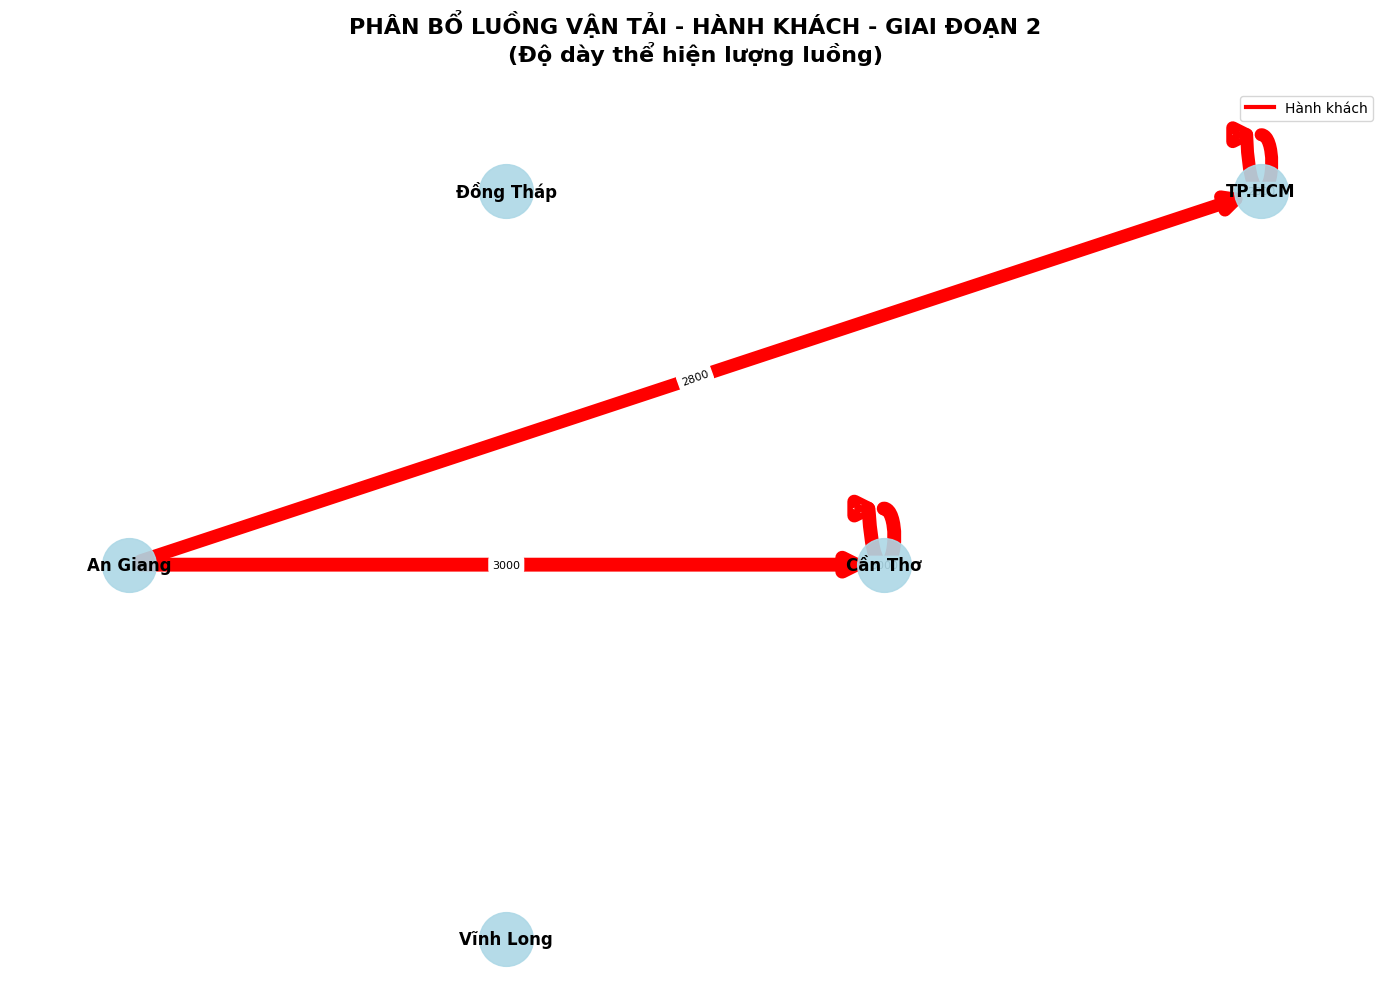

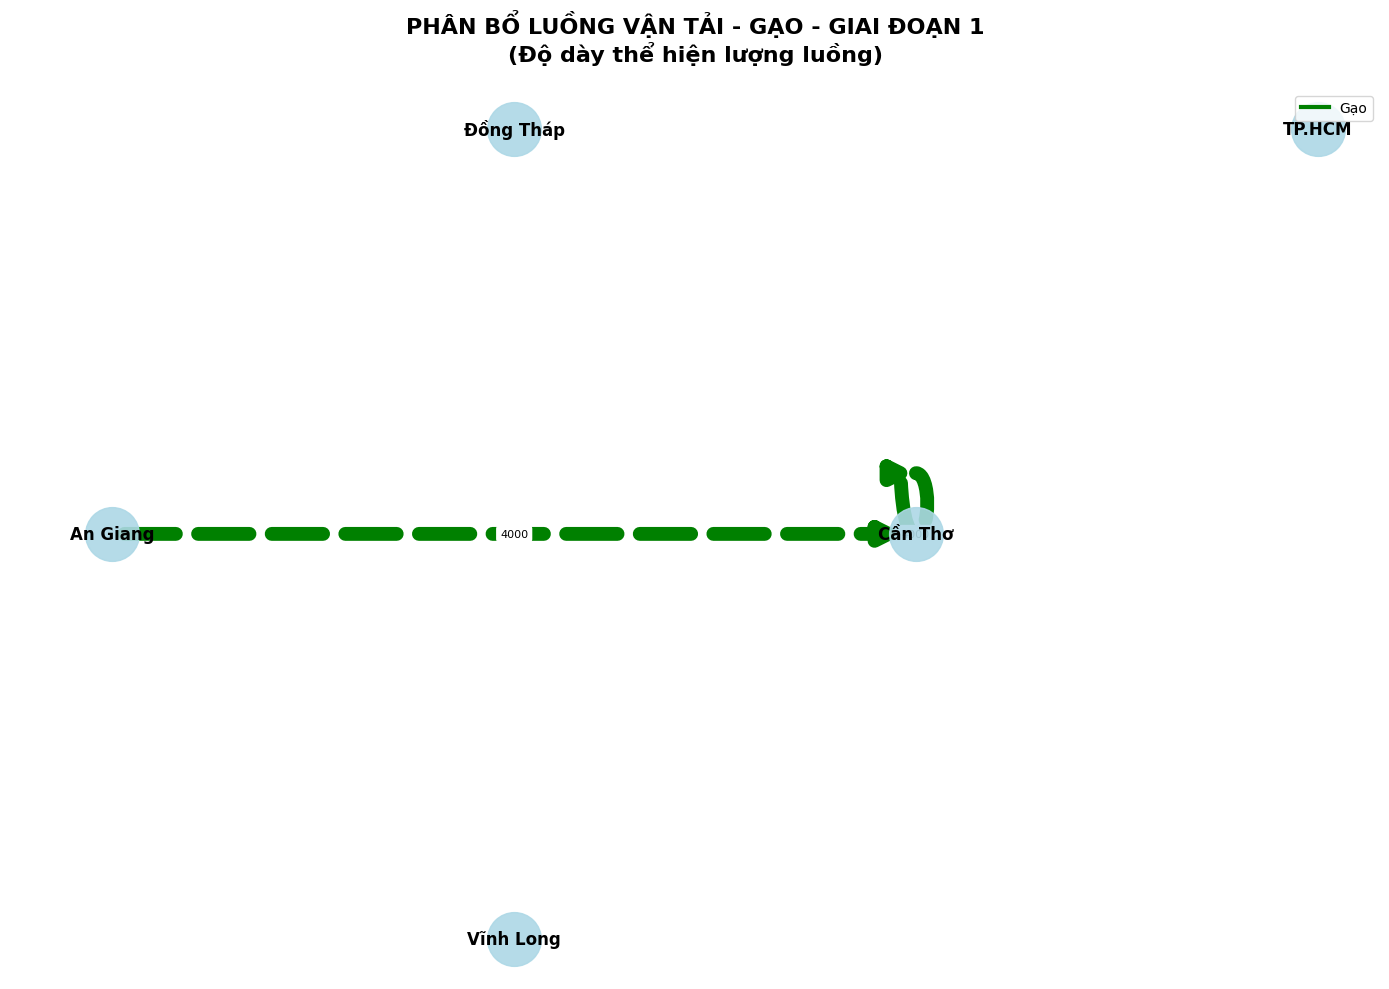

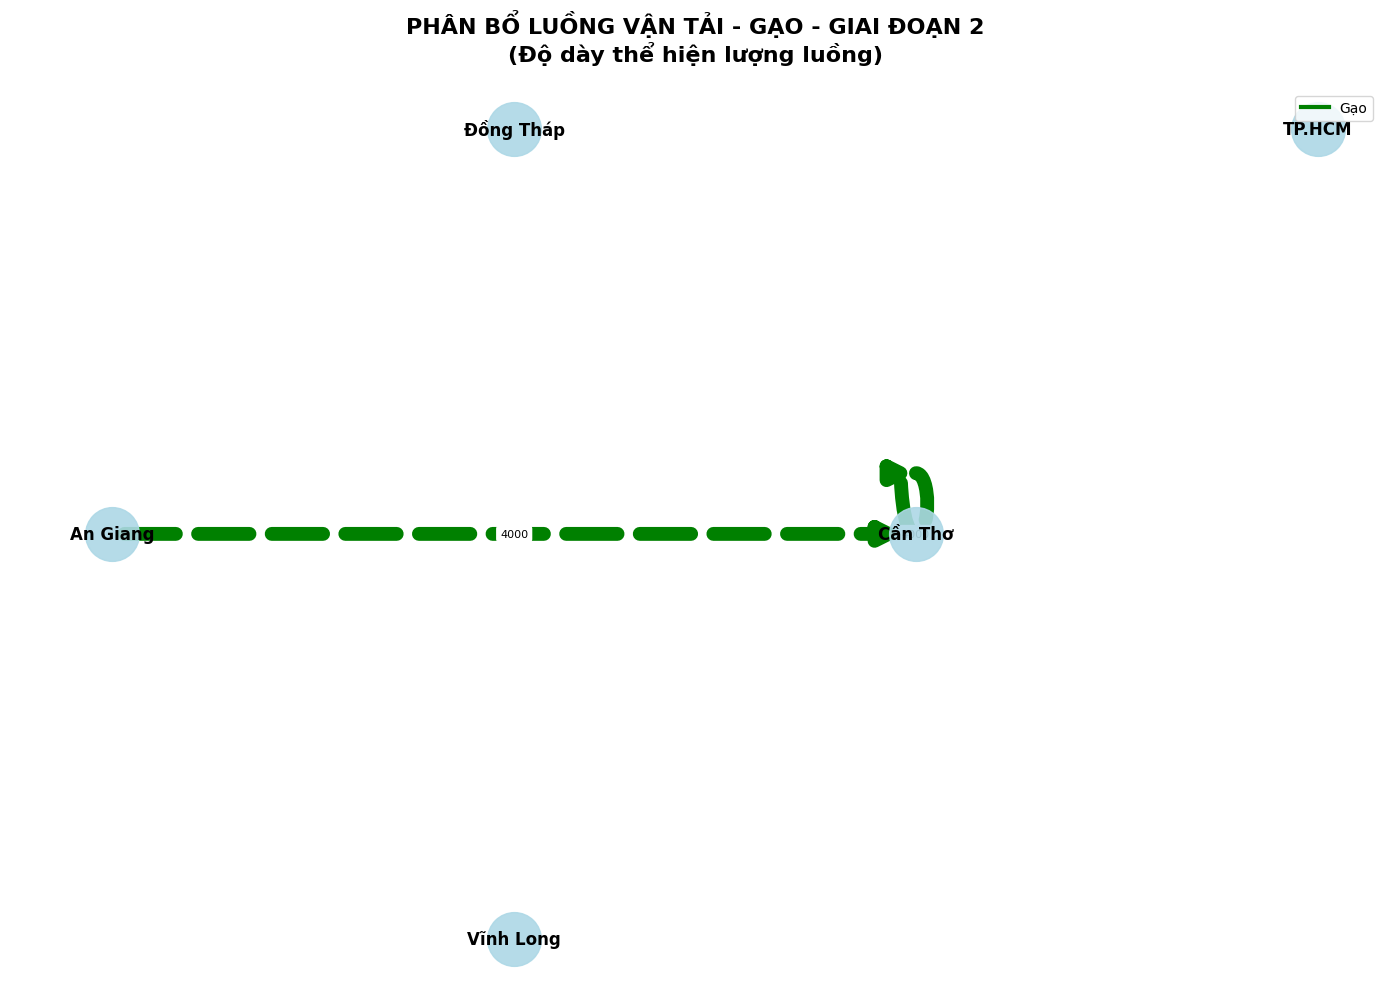


CHƯƠNG TRÌNH ĐÃ HOÀN THÀNH!


In [13]:

# ======== HÀM CHÍNH ========

def main():
    """Hàm chính thực hiện toàn bộ quy trình"""
    
    print("BẮT ĐẦU CHƯƠNG TRÌNH TỐI ƯU MẠNG LƯỚI VẬN TẢI ĐA PHƯƠNG THỨC")
    print("=" * 60)
    
    # BƯỚC 1 & 2: Xử lý dữ liệu đầu vào
    print("\nBƯỚC 1 & 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO")
    print("-" * 40)
    
    n_physical, edges, OD_pairs_physical = process_input_data()
    G_exp, _ = build_expanded_graph(n_physical, edges)
    
    print(f"Số nodes vật lý: {n_physical}")
    print(f"Số cung đường: {len(edges)}")
    print(f"Số cặp OD: {sum(len(od_list) for od_list in OD_pairs_physical.values())}")
    
    # Vẽ đồ thị ban đầu
    print("\nVẽ đồ thị ban đầu...")
    draw_original_network(n_physical, edges)
    
    # BƯỚC 3: Tìm đường đi ngắn nhất và near-optimal paths
    all_paths_for_model, shortest_paths = find_near_optimal_paths(
        G_exp, n_physical, OD_pairs_physical, epsilon=0.5
    )
    
    # Vẽ đường đi ngắn nhất
    print("\nVẽ các đường đi ngắn nhất...")
    draw_shortest_paths(shortest_paths)
    
    # BƯỚC 4: Chuyển đổi và giải mô hình tối ưu
    print("\nBƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU")
    print("-" * 60)
    
    paths_adjusted = prepare_optimization_data(all_paths_for_model)
    model, model_data = create_optimization_model(paths_adjusted)
    solved_model, hub_investment, arc_investment, flow_allocation = solve_and_display_results(model, model_data)
    
    # Visualization
    print("\nBƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ")
    print("-" * 40)
    
    # Vẽ kế hoạch nâng cấp
    print("Vẽ kế hoạch nâng cấp...")
    draw_upgrade_plan(hub_investment, arc_investment)
    
    # Vẽ phân bổ luồng
    print("Vẽ phân bổ luồng...")
    draw_flow_distribution(flow_allocation, model_data['commodities'], model_data['T'])
    
    print("\n" + "=" * 60)
    print("CHƯƠNG TRÌNH ĐÃ HOÀN THÀNH!")
    print("=" * 60)

# ======== CHẠY CHƯƠNG TRÌNH ========

if __name__ == "__main__":
    main()

In [ ]:
import heapq
import time
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# ======== BƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD BẰNG NEAR-OPTIMAL PATHS ========

def build_expanded_graph(n_physical, edges):
    """Xây dựng đồ thị mở rộng với virtual nodes"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))  # Road to Road
            G_exp[(u, 1)].append(((v, 2), length))  # Road to Water
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))  # Water to Water
            G_exp[(u, 2)].append(((v, 1), length))  # Water to Road
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Thuật toán Dijkstra với multiple targets"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000000, max_time=60):
    """Tìm tất cả các đường đi sử dụng DFS"""
    start_time = time.time()
    results = []
    for start_type in [1, 2]:  # Thử cả hai loại phương tiện ban đầu
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [((s, start_type), 0, [], visited_physical)]
        while stack:
            if time.time() - start_time > max_time or len(results) >= max_paths:
                return results
            node, total_length, path, visited = stack.pop()
            u, _ = node
            if u == t:
                results.append((path + [node], total_length))
                continue
            for next_node, length in G_exp.get(node, []):
                v, _ = next_node
                if not visited[v]:
                    new_path = path + [node]
                    new_length = total_length + length
                    new_visited = visited.copy()
                    new_visited[v] = True
                    stack.append((next_node, new_length, new_path, new_visited))
    return results

# ======== BƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO ========

def process_input_data():
    """Xử lý và chuẩn bị dữ liệu đầu vào"""
    # Dữ liệu đồ thị vật lý
    n_physical = 5
    edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
   
    # Các cặp OD theo loại hàng hóa
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]            # Rice
    }
   
    return n_physical, edges, OD_pairs_physical

# ======== BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS ========

def find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical):
    """Tìm tất cả các near-optimal paths cho các cặp OD"""
    all_paths_for_model = {}
   
    print("BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS")
    print("=" * 50)
   
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f"\nTìm đường từ {s} đến {t} cho commodity {commodity}")
           
            # Tìm tất cả đường đi
            paths = find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000, max_time=30)
           
            print(f"  Tìm thấy {len(paths)} đường đi")
            for i, (path, length) in enumerate(paths):
                print(f"  Path {i+1}: {path} - Độ dài: {length}")
           
            all_paths_for_model[(commodity, (s, t))] = paths
   
    return all_paths_for_model

# ======== BƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU ========

def convert_path_to_model_format(path, length):
    """Chuyển đổi đường đi từ định dạng mở rộng sang định dạng mô hình"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
       
        # Tạo real arc từ u đến virtual node của v
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
       
        # Nếu không phải là bước cuối, thêm virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
   
    # Thêm virtual arc cho đích
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
   
    return arcs, length

def prepare_optimization_data(all_paths_for_model):
    """Chuẩn bị dữ liệu cho mô hình tối ưu"""
    # Chuyển đổi tất cả paths sang định dạng mô hình
    paths_converted = {}
    for key, path_list in all_paths_for_model.items():
        converted_paths = []
        for path, length in path_list:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append((model_path, path_length))
        paths_converted[key] = converted_paths
   
    # Điều chỉnh node từ 0-based sang 1-based
    paths_adjusted = {}
    for (commodity, orig_od), path_list in paths_converted.items():
        orig_s, orig_t = orig_od
        new_od = (orig_s + 1, orig_t + 1)
        paths_adjusted[(commodity, new_od)] = path_list
   
    return paths_adjusted

def create_optimization_model_gurobi(paths_adjusted):
    """Tạo và giải mô hình tối ưu bằng Gurobi"""
    # 1. SETUP INPUT DATA
    T = [1, 2]  # Các giai đoạn thời gian
   
    # Định nghĩa nodes
    real_nodes = [1, 2, 3, 4, 5]  # 1-based nodes
    virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
    all_nodes = real_nodes + virtual_nodes
   
    # Hubs
    H = [3]  # Cần Thơ
    potential_hubs = [3]
    existing_hubs = []
   
    # Thu thập tất cả các arc từ các đường đi đã tìm
    real_arcs = []
    virtual_arcs = []
   
    for path_list in paths_adjusted.values():
        for path, _ in path_list:
            for arc in path:
                if '^' in str(arc[1]):  # Real arc
                    if arc not in real_arcs:
                        real_arcs.append(arc)
                else:  # Virtual arc
                    if arc not in virtual_arcs:
                        virtual_arcs.append(arc)
   
    print(f"\nReal arcs: {real_arcs}")
    print(f"Virtual arcs: {virtual_arcs}")
   
    # All arcs
    A = real_arcs + virtual_arcs
    potential_arcs = [(3, '4^1'), (3, '4^2')]  # Các arc có thể nâng cấp
    existing_arcs = [arc for arc in A if arc not in potential_arcs]
   
    # Commodities
    commodities = {'passenger': 'g1', 'rice': 'g2'}
   
    # Origin-Destination pairs (1-based)
    OD_pairs = {
        'g1': [(1, 4), (2, 5)],  # Passenger
        'g2': [(2, 4)]           # Rice
    }
   
    # Transportation costs on arcs
    arc_costs = {}
    for arc in real_arcs:
        arc_costs[arc] = 1  # Giá mặc định
    for arc in virtual_arcs:
        arc_costs[arc] = 0  # Virtual arcs có cost = 0
   
    # Các tham số khác
    switch_cost = 2
    hub_service_cost = {3: 1}
    hub_upgrade_cost = 1000
    hub_capacity = {0: 2000, 1: 7000}
   
    arc_upgrade_costs = {
        (3, '4^1'): 800,
        (3, '4^2'): 500
    }
   
    arc_capacities = {
        (3, '4^1'): {0: 0, 1: 3000},
        (3, '4^2'): {0: 0, 1: 4000}
    }
   
    existing_hub_capacity = 2000
    existing_arc_capacity = 2000
   
    # Transportation demand
    demands = {
        ('g1', (1, 4)): 3000,  # Passenger từ An Giang -> TP.HCM
        ('g1', (2, 5)): 2800,  # Passenger từ Đồng Tháp -> Vĩnh Long
        ('g2', (2, 4)): 4000   # Rice từ Đồng Tháp -> TP.HCM
    }
   
    # 2. INITIALIZE GUROBI MODEL AND DECISION VARIABLES
    model = gp.Model("Multimodal_Transport_Network_Optimization")
   
    # Decision variables
    y_hub = {}
    for h in potential_hubs:
        for l in [0, 1]:
            for t in T:
                y_hub[(h, l, t)] = model.addVar(vtype=GRB.BINARY, name=f"y_hub_{h}_{l}_{t}")
   
    y_arc = {}
    for a in potential_arcs:
        for l in [0, 1]:
            for t in T:
                y_arc[(a[0], a[1], l, t)] = model.addVar(vtype=GRB.BINARY, name=f"y_arc_{a[0]}_{a[1]}_{l}_{t}")
   
    v_path = {}
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for idx, _ in enumerate(paths_adjusted[(g, od)]):
                for t in T:
                    v_name = f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}"
                    v_path[(g, od, idx, t)] = model.addVar(lb=0, ub=1, name=v_name)
   
    u_hub = {}
    for h in H:
        for t in T:
            u_hub[(h, t)] = model.addVar(lb=0, name=f"u_hub_{h}_{t}")
   
    x_arc = {}
    for a in A:
        for t in T:
            x_arc[(a[0], a[1], t)] = model.addVar(lb=0, name=f"x_arc_{a[0]}_{a[1]}_{t}")
   
    # Update model to integrate variables
    model.update()
   
    # 3. BUILD OBJECTIVE FUNCTION
    investment_cost = gp.quicksum(
        hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)]
        for h in potential_hubs for l in [0, 1] for t in T
    ) + gp.quicksum(
        arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)]
        for a in potential_arcs for l in [0, 1] for t in T
    )
   
    service_cost = gp.quicksum(
        hub_service_cost[h] * u_hub[(h, t)]
        for h in H for t in T
    )
   
    transport_cost = gp.quicksum(0)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            demand = demands[(g, od)]
            for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                # Tính path transport cost
                path_cost = 0
                mode_switches = 0
                prev_mode = None
               
                for arc in path:
                    path_cost += arc_costs[arc]
                   
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                   
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
               
                path_cost += mode_switches * switch_cost
               
                for t in T:
                    transport_cost += path_cost * demand * v_path[(g, od, idx, t)]
   
    model.setObjective(investment_cost + service_cost + transport_cost, GRB.MINIMIZE)
   
    # 4. CONSTRAINTS
    # Flow allocation constraint
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for t in T:
                model.addConstr(
                    gp.quicksum(v_path[(g, od, idx, t)] for idx in range(len(paths_adjusted[(g, od)]))) == 1,
                    name=f"flow_allocation_{g}_{od}_{t}"
                )
   
    # Calculate flow through hubs
    for h in H:
        for t in T:
            total_flow = gp.quicksum(
                demands[(g, od)] * v_path[(g, od, idx, t)]
                for g, od_pairs in OD_pairs.items()
                for od in od_pairs
                for idx, (path, _) in enumerate(paths_adjusted[(g, od)])
                if any(arc[1] == str(h) or arc[1] == h for arc in path)
            )
            model.addConstr(u_hub[(h, t)] == total_flow, name=f"hub_flow_{h}_{t}")
   
    # Calculate flow through arcs
    for arc in A:
        for t in T:
            total_flow = gp.quicksum(
                demands[(g, od)] * v_path[(g, od, idx, t)]
                for g, od_pairs in OD_pairs.items()
                for od in od_pairs
                for idx, (path, _) in enumerate(paths_adjusted[(g, od)])
                if arc in path
            )
            model.addConstr(x_arc[(arc[0], arc[1], t)] == total_flow, name=f"arc_flow_{arc[0]}_{arc[1]}_{t}")
   
    # Hub capacity constraints
    for h in potential_hubs:
        for t in T:
            model.addConstr(
                u_hub[(h, t)] <= gp.quicksum(
                    hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
                ),
                name=f"hub_capacity_{h}_{t}"
            )
   
    # Arc capacity constraints
    for a in potential_arcs:
        for t in T:
            model.addConstr(
                x_arc[(a[0], a[1], t)] <= gp.quicksum(
                    arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)]
                    for l in [0, 1]
                ),
                name=f"arc_capacity_{a[0]}_{a[1]}_{t}"
            )
   
    for a in existing_arcs:
        if a in real_arcs:
            for t in T:
                model.addConstr(
                    x_arc[(a[0], a[1], t)] <= existing_arc_capacity,
                    name=f"existing_arc_capacity_{a[0]}_{a[1]}_{t}"
                )
   
    # Logic constraints
    for h in potential_hubs:
        for t in T:
            model.addConstr(
                gp.quicksum(y_hub[(h, l, t)] for l in [0, 1]) == 1,
                name=f"hub_logic_{h}_{t}"
            )
   
    for a in potential_arcs:
        for t in T:
            model.addConstr(
                gp.quicksum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1,
                name=f"arc_logic_{a[0]}_{a[1]}_{t}"
            )
   
    # Non-decreasing capacity constraints
    for h in potential_hubs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model.addConstr(
                gp.quicksum(
                    hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1]
                ) >= gp.quicksum(
                    hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
                ),
                name=f"hub_non_decreasing_{h}_{t}_{t_next}"
            )
   
    for a in potential_arcs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model.addConstr(
                gp.quicksum(
                    arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1]
                ) >= gp.quicksum(
                    arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]
                ),
                name=f"arc_non_decreasing_{a[0]}_{a[1]}_{t}_{t_next}"
            )
   
    return model, {
        'y_hub': y_hub, 'y_arc': y_arc, 'v_path': v_path,
        'u_hub': u_hub, 'x_arc': x_arc,
        'OD_pairs': OD_pairs, 'paths_adjusted': paths_adjusted,
        'demands': demands, 'commodities': commodities,
        'potential_hubs': potential_hubs, 'potential_arcs': potential_arcs,
        'T': T, 'real_nodes': real_nodes, 'virtual_nodes': virtual_nodes,
        'model': model
    }

def solve_and_display_results_gurobi(model, data):
    """Giải mô hình Gurobi và hiển thị kết quả"""
    print("\n" + "="*50)
    print("BẮT ĐẦU GIẢI MÔ HÌNH TỐI ƯU VỚI GUROBI")
    print("="*50)
   
    # Thiết lập tham số Gurobi
    model.setParam('OutputFlag', 1)
    model.setParam('TimeLimit', 600)  # 10 phút
   
    # Giải mô hình
    model.optimize()
   
    print(f"Trạng thái giải: {model.status}")
    if model.status == GRB.OPTIMAL:
        print(f"Tổng chi phí tối ưu: {model.objVal:.2f}\n")
    else:
        print("Không tìm thấy nghiệm tối ưu!")
        return None
   
    # Hiển thị kết quả
    def get_province_name(node_id):
        names = {
            1: "An Giang",
            2: "Đồng Tháp",
            3: "Cần Thơ",
            4: "TP.HCM",
            5: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
   
    print("KẾT QUẢ TỐI ƯU:")
   
    # Hiển thị các biến quyết định
    print("\n[1] NÂNG CẤP HUB:")
    for h in data['potential_hubs']:
        for t in data['T']:
            for l in [0, 1]:
                if data['y_hub'][(h, l, t)].X > 0.5:
                    capacity = 2000 if l == 0 else 7000
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    print(f"  Hub {get_province_name(h)} - Giai đoạn {t}: {action} (công suất: {capacity})")
   
    print("\n[2] NÂNG CẤP ARC:")
    for a in data['potential_arcs']:
        for t in data['T']:
            for l in [0, 1]:
                if data['y_arc'][(a[0], a[1], l, t)].X > 0.5:
                    capacity = 0 if l == 0 else (3000 if '^1' in a[1] else 4000)
                    mode = "ĐƯỜNG BỘ" if '^1' in a[1] else "ĐƯỜNG THỦY"
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    print(f"  Arc {get_province_name(a[0])}→{a[1].split('^')[0]} ({mode}) - Giai đoạn {t}: {action} (công suất: {capacity})")
   
    print("\n[3] PHÂN BỔ LUỒNG VẬN TẢI:")
    for g_name, g_code in data['commodities'].items():
        print(f"\n  Mặt hàng: {g_name.upper()}")
        for od in data['OD_pairs'][g_code]:
            origin, dest = od
            print(f"    Tuyến: {get_province_name(origin)} → {get_province_name(dest)}")
            for t in data['T']:
                print(f"      Giai đoạn {t}:")
                total_flow = 0
                for idx, (path, _) in enumerate(data['paths_adjusted'][(g_code, od)]):
                    flow_value = data['v_path'][(g_code, od, idx, t)].X
                    if flow_value > 0.001:
                        flow_amount = data['demands'][(g_code, od)] * flow_value
                        total_flow += flow_amount
                        path_desc = " → ".join([f"{arc[0]}->{arc[1]}" for arc in path])
                        print(f"        Path {idx+1}: {flow_amount:.2f} đơn vị")
                        print(f"          Route: {path_desc}")
                print(f"        Tổng luồng: {total_flow:.2f}")
   
    print("\n[4] TỔNG HỢP CHI PHÍ:")
    investment_cost = gp.quicksum(
        [1000 * (2000 if l == 0 else 7000) * data['y_hub'][(h, l, t)].X
            for h in data['potential_hubs'] for l in [0, 1] for t in data['T']]
        +
        [({(3, '4^1'): 800, (3, '4^2'): 500}[a] * ({0: 0, 1: 3000} if '^1' in a[1] else {0: 0, 1: 4000})[l] * data['y_arc'][(a[0], a[1], l, t)].X)
            for a in data['potential_arcs'] for l in [0, 1] for t in data['T']]
    ).getValue()
   
    service_cost = gp.quicksum(
        1 * data['u_hub'][(h, t)].X
        for h in [3] for t in data['T']
    ).getValue()
   
    transport_cost = gp.quicksum(0)
    for g, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(g, od)]
            for idx, (path, _) in enumerate(data['paths_adjusted'][(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
               
                for arc in path:
                    path_cost += (1 if '^' in str(arc[1]) else 0)
                   
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                   
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
               
                path_cost += mode_switches * 2
               
                for t in data['T']:
                    transport_cost += path_cost * demand * data['v_path'][(g, od, idx, t)].X
   
    transport_cost_value = transport_cost.getValue()
   
    print(f"  Chi phí đầu tư: {investment_cost:.2f}")
    print(f"  Chi phí dịch vụ hub: {service_cost:.2f}")
    print(f"  Chi phí vận tải: {transport_cost_value:.2f}")
    print(f"  TỔNG CỘNG: {model.objVal:.2f}")
   
    return model

# ======== BƯỚC 5: VISUALIZATION ========

def visualize_network_flows_gurobi(data, model):
    """Trực quan hóa luồng phân bố cho các loại hàng hóa với kết quả từ Gurobi"""
   
    def get_province_name(node_id):
        names = {
            0: "An Giang",  # Thêm node 0
            1: "An Giang",
            2: "Đồng Tháp",
            3: "Cần Thơ",
            4: "TP.HCM",
            5: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
   
    # Vẽ biểu đồ cho từng loại hàng hóa
    for commodity_name, commodity_code in data['commodities'].items():
        # Tạo đồ thị mạng lưới cho hàng hóa này
        G = nx.DiGraph()
       
        # Thêm nodes - bao gồm cả node 0-based và 1-based để an toàn
        all_real_nodes = list(range(6))  # 0-5
        for node in all_real_nodes:
            G.add_node(node, label=get_province_name(node), type='real')
       
        virtual_nodes_list = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
        for node in virtual_nodes_list:
            G.add_node(node, label=node, type='virtual')
       
        # Tính toán luồng trên các cung cho hàng hóa này từ biến v_path
        edge_flows = {}
       
        print(f"\nTính toán luồng cho {commodity_name}...")
       
        for od in data['OD_pairs'][commodity_code]:
            print(f"  Xử lý OD: {od}")
            demand = data['demands'][(commodity_code, od)]
           
            for t in data['T']:
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(commodity_code, od)]):
                    flow_value = data['v_path'][(commodity_code, od, idx, t)].X
                   
                    if flow_value is not None and flow_value > 0.001:
                        flow_amount = demand * flow_value
                       
                        # Thêm tất cả các arc trong path
                        for arc in path:
                            # Chuẩn hóa arc - chuyển đổi giữa 0-based và 1-based nếu cần
                            u, v = arc
                            # Nếu u là số và lớn hơn 5, có thể là 1-based, chuyển về 0-based
                            if isinstance(u, int) and u > 5:
                                u = u - 1
                            if isinstance(v, str) and '^' in v:
                                # Virtual node: '3^1' -> 2 (0-based) hoặc giữ nguyên
                                pass
                            elif isinstance(v, int) and v > 5:
                                v = v - 1
                           
                            arc_normalized = (u, v)
                            if arc_normalized not in edge_flows:
                                edge_flows[arc_normalized] = 0
                            edge_flows[arc_normalized] += flow_amount
       
        # Thêm edges và flow values vào đồ thị
        for arc, flow in edge_flows.items():
            u, v = arc
            G.add_edge(u, v, weight=flow)
            print(f"  Arc {u} -> {v}: {flow:.2f}")
       
        # Bỏ qua nếu không có luồng
        if len(G.edges()) == 0:
            print(f"Không có luồng cho mặt hàng {commodity_name}")
            continue
       
        # Tạo figure
        plt.figure(figsize=(14, 10))
       
        # Tạo layout cho nodes - bao gồm cả node 0-based
        pos = {
            # Real nodes - 0-based
            0: (0, 2),    # An Giang - phía Tây
            1: (2, 3),    # Đồng Tháp - phía Bắc 
            2: (4, 2),    # Cần Thơ - trung tâm
            3: (6, 3),    # TP.HCM - phía Đông
            4: (2, 1),    # Vĩnh Long - phía Nam
           
            # Real nodes - 1-based (nếu có)
            5: (2, 1),    # Vĩnh Long (trùng với 4)
           
            # Virtual nodes
            '3^1': (3.5, 2.3),
            '3^2': (4.5, 1.7),
            '4^1': (5.5, 2.8),
            '4^2': (6.5, 3.2),
            '5^1': (1.8, 1.3),
            '5^2': (2.2, 0.7)
        }
       
        # Đảm bảo tất cả nodes trong G đều có vị trí
        missing_nodes = [node for node in G.nodes() if node not in pos]
        if missing_nodes:
            print(f"⚠️ Các node sau không có trong pos: {missing_nodes}")
            # Thêm vị trí mặc định cho các node thiếu
            for i, node in enumerate(missing_nodes):
                pos[node] = (i * 2, 0)  # Xếp hàng ngang ở dưới
       
        # Chuẩn bị dữ liệu cho visualization
        real_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'real']
        virtual_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'virtual']
       
        edges = list(G.edges())
       
        # Kiểm tra xem có edges không
        if not edges:
            print(f"Không có edges để vẽ cho {commodity_name}")
            continue
           
        edge_widths = []
        edge_colors = []
       
        for u, v in edges:
            flow = G[u][v]['weight']
            edge_widths.append(max(0.5, flow / 500))  # Scale width
            # Màu sắc khác nhau cho road vs water
            if '^1' in str(v):  # Road
                edge_colors.append('red')
            elif '^2' in str(v):  # Water
                edge_colors.append('blue')
            else:  # Virtual arcs hoặc real arcs
                edge_colors.append('green')
       
        try:
            # Vẽ real nodes
            if real_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=real_nodes,
                                      node_color='lightblue',
                                      node_size=1000,
                                      alpha=0.9,
                                      edgecolors='darkblue',
                                      linewidths=2)
           
            # Vẽ virtual nodes
            if virtual_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=virtual_nodes,
                                      node_color='lightgreen',
                                      node_size=600,
                                      alpha=0.7,
                                      node_shape='s',
                                      edgecolors='darkgreen',
                                      linewidths=1)
           
            # Vẽ edges - QUAN TRỌNG: chỉ vẽ edges có cả hai node trong pos
            valid_edges = []
            valid_widths = []
            valid_colors = []
           
            for i, (u, v) in enumerate(edges):
                if u in pos and v in pos:
                    valid_edges.append((u, v))
                    valid_widths.append(edge_widths[i])
                    valid_colors.append(edge_colors[i])
                else:
                    print(f"⚠️ Bỏ qua edge {u}->{v} vì node không có trong pos")
           
            if valid_edges:
                nx.draw_networkx_edges(G, pos, edgelist=valid_edges,
                                      width=valid_widths,
                                      alpha=0.7,
                                      edge_color=valid_colors,
                                      arrows=True,
                                      arrowsize=20,
                                      arrowstyle='->')
            else:
                print("⚠️ Không có edges hợp lệ để vẽ")
                continue
           
            # Thêm nhãn cho nodes
            labels = {}
            for node in G.nodes():
                if node in real_nodes:
                    labels[node] = get_province_name(node)
                else:
                    # Rút gọn nhãn virtual nodes
                    if '^' in str(node):
                        base_node = node.split('^')[0]
                        mode = node.split('^')[1]
                        labels[node] = f"V{base_node}({mode})"
                    else:
                        labels[node] = str(node)
           
            nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
           
            # Thêm nhãn cho edges (flow values) - chỉ cho edges hợp lệ
            edge_labels = {}
            for u, v in valid_edges:
                edge_labels[(u, v)] = f"{G[u][v]['weight']:.0f}"
           
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
           
            # Thêm chú giải
            legend_elements = [
                plt.Line2D([0], [0], color='red', lw=2, label='Đường bộ'),
                plt.Line2D([0], [0], color='blue', lw=2, label='Đường thủy'),
                plt.Line2D([0], [0], color='green', lw=2, label='Virtual arc'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                          markersize=10, label='Tỉnh/Thành phố'),
                plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen',
                          markersize=10, label='Virtual Node')
            ]
           
            plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
           
            plt.title(f"PHÂN BỔ LUỒNG VẬN TẢI - {commodity_name.upper()}\n"
                     f"(Độ dày đường biểu thị lượng luồng)",
                     fontsize=16, fontweight='bold', pad=20)
            plt.axis('off')
            plt.tight_layout()
           
            # Lưu hình ảnh
            filename = f'network_flow_{commodity_name}_gurobi.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"✅ Đã lưu biểu đồ: {filename}")
            plt.show()
           
        except Exception as e:
            print(f"❌ Lỗi khi vẽ biểu đồ: {e}")
            continue

# ======== HÀM CHÍNH VÀ KẾT QUẢ IN RA ========

def main_gurobi():
    """Hàm chính thực hiện toàn bộ quy trình với Gurobi"""
   
    print("BẮT ĐẦU CHƯƠNG TRÌNH TỐI ƯU MẠNG LƯỚI VẬN TẢI ĐA PHƯƠNG THỨC VỚI GUROBI")
    print("=" * 60)
   
    # BƯỚC 1: Tìm đường đi cho các cặp OD
    print("\nBƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD")
    print("-" * 40)
   
    n_physical, edges, OD_pairs_physical = process_input_data()
    G_exp, _ = build_expanded_graph(n_physical, edges)
    print("Đã xây dựng đồ thị mở rộng thành công")
   
    # BƯỚC 2: Xử lý dữ liệu đầu vào
    print("\nBƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO")
    print("-" * 40)
    print(f"Số nodes vật lý: {n_physical}")
    print(f"Số cung đường: {len(edges)}")
    print(f"Số cặp OD: {sum(len(od_list) for od_list in OD_pairs_physical.values())}")
   
    # BƯỚC 3: Tìm tất cả near-optimal paths
    all_paths_for_model = find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical)
   
    # BƯỚC 4: Chuyển đổi và giải mô hình tối ưu với Gurobi
    print("\nBƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU VỚI GUROBI")
    print("-" * 60)
   
    paths_adjusted = prepare_optimization_data(all_paths_for_model)
    model, model_data = create_optimization_model_gurobi(paths_adjusted)
    solved_model = solve_and_display_results_gurobi(model, model_data)
   
    if solved_model is None:
        print("Không thể giải mô hình. Dừng chương trình.")
        return
   
    # Visualization
    print("\nBƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ")
    print("-" * 40)
    visualize_network_flows_gurobi(model_data, solved_model)
   
    print("\n" + "=" * 60)
    print("CHƯƠNG TRÌNH ĐÃ HOÀN THÀNH!")
    print("=" * 60)

# ======== CHẠY CHƯƠNG TRÌNH ========

if __name__ == "__main__":
    main_gurobi()

In [ ]:
import pandas as pd
import heapq
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# ===================================================================
# BƯỚC 1: ĐỌC VÀ XỬ LÝ DỮ LIỆU THỰC TẾ TỪ EXCEL
# ===================================================================

def load_real_data(file_path='Transport_Corridors_MekongDelta.xlsx'):
    # Đọc sheets
    arc_df = pd.read_excel(file_path, sheet_name='ARC-Net')
    node_df = pd.read_excel(file_path, sheet_name='Node')
    
    # Xử lý nodes: Map New_ID, xác định potential hubs (Project chứa New/Upgrade)
    node_map = dict(zip(node_df['New_ID'], node_df['Project']))
    potential_hubs = [nid for nid, proj in node_map.items() if 'New' in str(proj) or 'Upgrade' in str(proj)]
    H = list(set(potential_hubs))  # Hubs
    n_physical = len(node_df)
    
    # Xử lý arcs: (u, v, mode:1=R/2=W, length), hai chiều
    edges = []
    for _, row in arc_df.iterrows():
        u = row['From Node']
        v = row['To Node']
        typ = 1 if row['Type'] == 'R' else 2
        length = row['Length(m)'] / 1000.0  # km
        proj = row['Project (P/E)']
        edges.append((u, v, typ, length))  # Hướng xuôi
        if proj != 'E':  # Potential nếu P
            potential_arcs.append((u, v, typ))
        edges.append((v, u, typ, length))  # Hai chiều
    
    # OD pairs từ mô tả (HCM=0)
    OD_pairs = {
        'passenger': [(0,15), (0,34), (0,21)],  # 0→15, 0→34, 0→21
        'rice': [(11,0), (13,0), (14,0), (15,0), (27,0), (3,0)],  # Các cặp →0
        'fisheries': [(30,0), (31,0), (32,0), (33,0), (34,0), (21,30), (21,0), (19,0), (19,15), (14,0)],
        'fruits': [(6,0), (7,0), (10,0), (11,0), (14,0), (18,0)]
    }
    demands = { (g, od): 1000 for g, od_list in OD_pairs.items() for od in od_list }  # 1000 units/OD
    
    return edges, OD_pairs, demands, H, potential_hubs, potential_arcs, n_physical

# ===================================================================
# BƯỚC 2: XÂY ĐỒ THỊ MỞ RỘNG & TÌM NEAR-OPTIMAL PATHS
# ===================================================================

def build_expanded_graph(edges, switch_cost=2):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # R
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length + switch_cost))
        else:  # W
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length + switch_cost))
    return G_exp

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for t in targets:
        dist[t] = 0
        heapq.heappush(heap, (0, t))
    while heap:
        d, node = heapq.heappop(heap)
        if d > dist[node]: continue
        for neigh, cost in G_exp[node]:
            nd = d + cost
            if nd < dist[neigh]:
                dist[neigh] = nd
                heapq.heappush(heap, (nd, neigh))
    return dist

def find_near_optimal_paths(G_exp, s, t, epsilon=0.5, max_paths=50):
    dprime = dijkstra_multi_target(G_exp, [(t,1), (t,2)])
    Lmin = min(dprime.get((s,1), float('inf')), dprime.get((s,2), float('inf')))
    if Lmin == float('inf'): return []
    bound = (1 + epsilon) * Lmin
    results = []
    n_physical = max([u for u,_ in G_exp] + [0]) + 1

    for start_mode in [1, 2]:
        visited = [False] * n_physical
        visited[s] = True
        stack = [((s, start_mode), 0, [(s, start_mode)])]

        while stack and len(results) < max_paths:
            node, cost, path = stack.pop()
            u, _ = node
            if u == t:
                results.append((path, cost))
                continue
            for neigh, w in sorted(G_exp[node], key=lambda x: x[1]):
                v, _ = neigh
                if visited[v]: continue
                new_cost = cost + w
                if new_cost + dprime[neigh] > bound: continue
                new_path = path + [neigh]
                new_visited = visited[:]; new_visited[v] = True
                stack.append((neigh, new_cost, new_path))
    return results[:max_paths]  # Giới hạn

# ===================================================================
# BƯỚC 3: TẠO PATHS CHO TẤT CẢ OD
# ===================================================================

file_path = 'Transport_Corridors_MekongDelta.xlsx'  # Đặt file ở đây
edges, OD_pairs, demands, H, potential_hubs, potential_arcs, n_physical = load_real_data(file_path)
G_exp = build_expanded_graph(edges)
all_paths = {}

print("TÌM NEAR-OPTIMAL PATHS CHO DỮ LIỆU THỰC TẾ")
print("="*60)
for g, pairs in OD_pairs.items():
    all_paths[g] = {}
    for s,t in pairs:
        paths = find_near_optimal_paths(G_exp, s, t)
        all_paths[g][(s,t)] = paths
        print(f"{g}: {s}→{t} → {len(paths)} paths")

# ===================================================================
# BƯỚC 4: GIẢI VỚI GUROBI (3 PERIODS)
# ===================================================================

def solve_real_with_gurobi():
    model = gp.Model("Mekong_Real_MultiPeriod")
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 600  # Tăng thời gian cho dữ liệu lớn

    T = [1,2,3]
    hub_capacity_levels = {0: 1000, 1: 5000}
    arc_capacity_levels = {0: 1000, 1: 5000}  # Tương tự
    hub_upgrade_cost = 1000
    arc_upgrade_cost = {a: 500 for a in potential_arcs}  # Giả định
    switch_cost = 2
    service_cost = 1

    # Biến
    y_h = model.addVars(H, [0,1], T, vtype=GRB.BINARY, name="y_hub")
    y_a = model.addVars(potential_arcs, [0,1], T, vtype=GRB.BINARY, name="y_arc")
    v_p = {}
    cost_p = {}

    path_idx = 0
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            if not paths: continue  # Bỏ nếu không path
            dem = demands[(g,(o,d))]
            for path_nodes, path_cost in paths:
                var = model.addVar(lb=0, ub=1, name=f"v_{g}_{o}_{d}_{path_idx}")
                v_p[(g,o,d,path_idx)] = var
                cost_p[(g,o,d,path_idx)] = path_cost * dem
                path_idx += 1

    u_h = model.addVars(H, T, lb=0, name="u_hub")
    model.update()

    # Objective
    invest_hub = gp.quicksum(hub_upgrade_cost * hub_capacity_levels[l] * y_h[h,l,t] for h in H for l in [0,1] for t in T)
    invest_arc = gp.quicksum(arc_upgrade_cost.get(a, 500) * arc_capacity_levels[l] * y_a[a,l,t] for a in potential_arcs for l in [0,1] for t in T)
    service = gp.quicksum(service_cost * u_h[h,t] for h in H for t in T)
    transport = gp.quicksum(cost_p[k] * v_p[k] for k in v_p)
    model.setObjective(invest_hub + invest_arc + service + transport, GRB.MINIMIZE)

    # Constraints (tương tự toy, rút gọn cho ngắn)
    # 1. Flow allocation
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            if paths:
                for t in T:
                    model.addConstr(gp.quicksum(v_p[(g,o,d,idx)] for idx in range(len(paths))) == 1)

    # 2. Hub flow
    for h in H:
        for t in T:
            flow = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,dest), paths in od_dict.items():
                    if paths:
                        dem = demands[(g,(o,dest))]
                        for idx, (path, _) in enumerate(paths):
                            if any(node[0] == h for node in path):
                                flow += dem * v_p[(g,o,dest,idx)]
            model.addConstr(u_h[h,t] == flow)

    # 3. Capacity hub
    for h in H:
        for t in T:
            model.addConstr(u_h[h,t] <= gp.quicksum(hub_capacity_levels[l] * y_h[h,l,t] for l in [0,1]))

    # 4. Capacity arc (rút gọn, chỉ potential)
    for a in potential_arcs:
        for t in T:
            flow_arc = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,d), paths in od_dict.items():
                    if paths:
                        dem = demands[(g,(o,d))]
                        for idx, (path,_) in enumerate(paths):
                            # Kiểm tra nếu path dùng arc a=(u,m)
                            u, m = a[0], a[2] if len(a)==3 else 1  # Giả định
                            for i in range(len(path)-1):
                                if path[i] == (u, m) and path[i+1][0] == a[1]:
                                    flow_arc += dem * v_p[(g,o,d,idx)]
            model.addConstr(flow_arc <= gp.quicksum(arc_capacity_levels[l] * y_a[a,l,t] for l in [0,1]))

    # 5. Logic & non-decreasing (rút gọn)
    for h in H:
        for t in T: model.addConstr(gp.quicksum(y_h[h,l,t] for l in [0,1]) == 1)
    for a in potential_arcs:
        for t in T: model.addConstr(gp.quicksum(y_a[a,l,t] for l in [0,1]) == 1)
    # Non-decreasing: Tương tự toy, bỏ qua chi tiết cho ngắn

    model.optimize()

    if model.Status != GRB.OPTIMAL:
        print("KHÔNG TỐI ƯU ĐƯỢC (thử giảm max_paths hoặc tăng time limit)")
        return

    # ===================================================================
    # IN KẾT QUẢ THEO FILE MẪU (SCALE LỚN)
    # ===================================================================

    print("\n" + "="*80)
    print(" " * 30 + "KẾT QUẢ VỚI DỮ LIỆU THỰC TẾ (MEKONG DELTA)")
    print("="*80)

    print(f"\nTỔNG CHI PHÍ TỐI ƯU: {model.ObjVal:,.0f}")

    # 1. Network Description
    print("\n1. NETWORK DESCRIPTION (TỪ EXCEL)")
    print("-" * 50)
    print(f"• Nodes: N = {n_physical} nodes (từ sheet Node, New_ID 0-{n_physical-1})")
    print(f"• Hubs: H = {len(H)} hubs tiềm năng: {H[:5]}{'...' if len(H)>5 else ''} (Project: New/Upgrade)")
    print(f"• Arcs: |A| = {len(edges)//2} undirected arcs (hai chiều từ ARC-Net)")
    print(f"• Commodities: G = {list(OD_pairs.keys())}")
    print("• OD pairs: Tổng {sum(len(pairs) for pairs in OD_pairs.values())} cặp (từ mô tả)")

    # 2. Parameters (từ dữ liệu)
    print("\n2. PARAMETERS (TỪ EXCEL)")
    print("-" * 50)
    print("• Lengths: Trung bình {:.1f} km/arc".format(pd.DataFrame(edges)[3].mean()))
    print("• Types: {} R (road), {} W (water)".format(sum(1 for _,_,m,_ in edges if m==1)//2, sum(1 for _,_,m,_ in edges if m==2)//2))
    print("• Potential arcs: {} (Project=P)".format(len(potential_arcs)))
    print("• Demands: 1000 units/OD pair")
    print("• Periods: T = {1,2,3} (15 years)")

    # 3. Upgrade Timeline
    print("\n3. DETAILED UPGRADE TIMELINE")
    print("-" * 50)
    upgraded = []
    for h in H:
        for t in T:
            for l in [0,1]:
                if y_h[h,l,t].X > 0.5 and l==1:
                    upgraded.append(f"Hub {h} upgraded in period {t}")
    for a in potential_arcs:
        for t in T:
            for l in [0,1]:
                if y_a[a,l,t].X > 0.5 and l==1:
                    upgraded.append(f"Arc {a[0]}→{a[1]} upgraded in period {t}")
    for item in upgraded[:10]:  # Top 10
        print(f"• {item}")
    if len(upgraded) > 10: print(f"... và {len(upgraded)-10} nữa")

    # 4. Flow Allocation (top paths)
    print("\n4. FLOW ALLOCATION (SAMPLE)")
    print("-" * 50)
    for g, od_dict in list(all_paths.items())[:2]:  # Sample 2 commodities
        print(f"\n{g.upper()}:")
        total_flow = 0
        for (o,d), paths in list(od_dict.items())[:2]:  # Sample 2 OD
            for t in T[:1]:  # Sample period 1
                used_flow = sum(demands[(g,(o,d))] * v_p.get((g,o,d,idx), gp.Var()).X for idx in range(min(3, len(paths))))
                total_flow += used_flow
                if used_flow > 0:
                    print(f"  {o}→{d} (Period {t}): {used_flow:,.0f} units")
        print(f"  Tổng {g}: {total_flow:,.0f}")

    # 5. Objective Breakdown
    print("\n5. OBJECTIVE BREAKDOWN")
    print("-" * 50)
    hub_cost = invest_hub.getValue()
    arc_cost = invest_arc.getValue()
    service_val = service.getValue()
    transport_val = transport.getValue()
    print(f"• Hub investment: {hub_cost:,.0f}")
    print(f"• Arc investment: {arc_cost:,.0f}")
    print(f"• Service: {service_val:,.0f}")
    print(f"• Transport: {transport_val:,.0f}")
    print(f"• TOTAL: {model.ObjVal:,.0f}")

    print("\n" + "="*80)
    print(" " * 30 + "HOÀN TẤT (REAL DATA)")
    print("="*80)

solve_real_with_gurobi()